# =======================
# = Glazsiou study | Transition plot =
# =======================

The purpose of this notebook is to produce a plot of the transition probabilities between the labels attributed to inter-test intervals that are seen in early, middle, and late stages of living with type-2 diabetes mellitus.

I define the early stage as the period up to fifth HbA1c inter-test interval; the middle stage as the period up to tenth HbA1c inter-test interval; and the late stage as the period up to fifteenth HbA1c inter-test interval.

### Notes on counting

It is possible that a person's records can have more or fewer valid values for the inter-test intervals than they have test events. For example, a person's records might include 5 test events - and, thus, 4 inter-test intervals - but 1 of the inter-test intervals might have an `NA` value because, for example, the interval duration is too short for valid HbA1c test results. This will provide 3 valid values for the inter-test intervals. Also, a person's records can indicate 6 valid values because the 'Adjust' state can be applied to and open-ended period after the final test in a record because 'Adjust' can be satisfied by a change in prescription regardless of the duration of the inter-test interval. This open-ended period has no valid concept of interval because of its open-endedness so 'Hold' and 'Monitor' values are not computable.

It is for these reasons that I define records by the count of consecutive, valid inter-test intervals starting from the first test after their initial diagnosis ("interval" implying the period is not open-ended; At a later date, I might redefine the 'Adjust' state to not be satisfied by open-ended final periods). The requirement for the valid inter-test intervals to be consecutive is needed so that the calculated transition probabilities correspond to consecutive test events. Also the requirement for the first test to be the first after their initial diagnosis is needed to align the sequences by the index of their test event.

The situation is further complicated by the fact that we are interested in the transition probabilities between the values of inter-test intervals. For a sequence of `n` test events, there will ne `n-1` inter-test intervals and `n-2` transitions between the interval labels. Taking the early stage as an example, to study five inter-test intervals, we must select six test events, which will provide only four transitions between the interval labels.

### Other requirements

1. to provide the transition matrices and diagrams for early, middle, and late stages of living with type-2 diabetes mellitus.
2. to provide the process-mining trace variants in each of the data subsets described in 1.
3. include an indication of the self-transitions in the transition plots in two ways:
    1. by including the count as an annotation at the centre of the marker point.
    2. by adding a colour gradient for the marker that is based on the count.
4. check that the transition probabilities all sum to 1, as expected.
5. produce plots with each additional layer so that the story of the plot can be built up, during presentations.

The notebook is coded entirely in R.

In [ ]:
~~~~ Check all instances of `dplyr::arrange()` to make sure that the prior grouping is still applied. ~~~~~

# Get requisite packages.

In [385]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery # Version ‘1.5.1’
    ,data.table # Version ‘1.16.0’
    ,GGally # Version ‘2.2.1’
    ,ggraph
    ,ggimage
    ,gtable # Version ‘0.3.6’
    ,grid # Version ‘4.4.1’
    ,gridExtra # Version ‘2.3’
    ,IRdisplay
    ,kableExtra
    ,paletteer # Version ‘1.6.0’
    ,readr # Version ‘2.1.5’
    ,tidytext # Version ‘0.4.2’
    ,tidyverse # Version ‘2.0.0’
    ,TraMineR # Version ‘2.2.10’
    ,TraMineRextras # Version ‘0.6.8’
)
#devtools::install_github("davidsjoberg/ggsankey")
#remove.packages("ggsankey")
devtools::install_github("ciaranmci/ggsankey", force = TRUE )

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘yulab.utils’, ‘gridGraphics’, ‘ggfun’, ‘ggiraph’, ‘ggplotify’, ‘magick’


Warning message in utils::install.packages(package, ...):
“installation of package ‘magick’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘ggimage’ had non-zero exit status”
Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ggimage’”
Warning message in pacman::p_load(bigrquery, data.table, GGally, ggraph, ggimage, :
“Failed to install/load:
ggimage”




── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/var/tmp/Rtmp8hDbnA/remotes149536be9dfe/ciaranmci-ggsankey-821b0e3/DESCRIPTION’ ... OK
* preparing ‘ggsankey’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsankey_0.0.99999.tar.gz’



Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



# Set cohort parameters

In [2]:
# Study dates
# ## The date before which a patient must have had their diagnosis.
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
# ## The date after which test and intervention records will be studied.
followup_delay_in_years <- 0
date_followup_start <- date_diagnosis_threshold + lubridate::years( followup_delay_in_years )
# ## The date before which test and intervention records will be studied.
followup_duration_in_years <- 10
date_followup_end <- date_followup_start + lubridate::years( followup_duration_in_years )

# Set the duration of the window back in time to review prescriptions when identifying
# the HMA status.
HMA_adjust_lookBack_window <- lubridate::weeks( 16 )

# Set upper and lower thresholds for acceptable values of the test.
test_value_cutoff_lower <- 20
test_value_cutoff_upper <- 200

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- followup_duration_in_years*2

# Set the window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Generate the cohort.

In [3]:
source('RESHAPE_cohort_generator.r')

Warning message:
“The `check_from` argument of `tbl_sql()` is deprecated as of dbplyr 2.5.0.
ℹ The deprecated feature was likely used in the dbplyr package.
  Please report the issue at <https://github.com/tidyverse/dbplyr/issues>.”
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [4]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Create STS objects.

In [5]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [6]:
paste( date_diagnosis_threshold,": The date before which a patient must have had their diagnosis." )
paste( followup_delay_in_years,": The follow-up delay, in years." )
paste( followup_duration_in_years,": The follow-up duration, in years." )
paste( date_followup_start,": The date after which test and intervention records will be studied." )
paste( date_followup_end,": The date before which test and intervention records will be studied." )
paste( HMA_adjust_lookBack_window, ": The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period.")
paste( test_value_cutoff_lower,": Lower threshold for acceptable values of the test." )
paste( test_value_cutoff_upper,": Upper threshold for acceptable values of the test." )
paste( window_repeated_prescription_months, ": The window within which to search for repeated (but not repeat) prescriptions.")
paste( n_iterations,": Number of tests, treatments,or iteration after diagnosis that should be tracked." )
paste( multimorb_inclusion_window_months,": The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months." )
paste( multimorb_gap_window_months,": The window outwith which at least two mutimorbidity diagnoses must be of each other, in months." )


[1] "2000-01-01 : The date before which a patient must have had their diagnosis."

[1] "0 : The follow-up delay, in years."

[1] "10 : The follow-up duration, in years."

[1] "2000-01-01 : The date after which test and intervention records will be studied."

[1] "2010-01-01 : The date before which test and intervention records will be studied."

[1] "112d 0H 0M 0S : The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period."

[1] "20 : Lower threshold for acceptable values of the test."

[1] "200 : Upper threshold for acceptable values of the test."

[1] "3 : The window within which to search for repeated (but not repeat) prescriptions."

[1] "20 : Number of tests, treatments,or iteration after diagnosis that should be tracked."

[1] "60 : The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."

[1] "1 : The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."

# Create data subsets based on number of test events in the record.

In [215]:
# I will need to identify the `person_id` in `df_log_PandT_longFormat_simplified_StrataLabels` and then filter the STS object for those ID numbers.

pids_temp <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Select columns of interest.
    dplyr::select( person_id, idx_test_interval, event_name, HMA ) %>%
    # Filter for test events with valid values for the inter-test interval.
    dplyr::filter( event_name == "test", !is.na( HMA ) ) %>%
    # Define the criteria where a person's record is valid.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( idx_test_interval, .by_group = TRUE ) %>%
    dplyr::mutate(
        start_from_1 = dplyr::first( idx_test_interval == 1 )
        ,consecutive = ( ( idx_test_interval - lag( idx_test_interval ) ) == 1 )
        ,consecutive = dplyr::if_else( is.na( consecutive ), TRUE, consecutive )
    ) %>%
    dplyr::rowwise() %>%
    dplyr::mutate( consecutive_and_starts_from_1 = all( start_from_1, consecutive ) ) %>%
    dplyr::ungroup()

pids_exactly_5 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) == 5 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_exactly_10 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) == 10 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_exactly_15 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) == 15 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )

rm( pids_temp )

# Create the transition matrices

Create a tibble of the transitions from `node` to `next_node`, for each data subset.

In [225]:
# Define a function that creates a tibble of the transitions from `node` to `next_node`.
fnc__make_transition_tibble <-
    function(
        sts = NULL   # The STS object to filter.
        ,pids = NULL # A vector of the `person_id` values to filter for.
    )
{
    # Check that arguments are valid.
    if( is.null( sts ) ) { stop( "\nArgument `sts` was not provided.\n" ) }
    if( is.null( pids ) ) { stop( "\nArgument `pids` was not provided.\n" ) }
    
    # Create the transition tibble.
    tbbl_transitions <-
        sts %>%
        # Filter for the cohort with exactly 5 tests on record.
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::filter( person_id %in% pids ) %>%
        tibble::column_to_rownames( "person_id" ) %>%
        # Remove the default start node.
        ggsankey::make_long( colnames( . ) ) %>%
        # Reorder the `node` variable values to match their colours.
        dplyr::mutate_at(
            .vars = vars( node, next_node )
            ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
        ) %>%
        # Remove the 'Unobserved' state.
        dplyr::filter( node != "Unobserved", next_node != "Unobserved" )%>%
        suppressWarnings()
        
    return( tbbl_transitions )
}

# Create the transitions tibbles.
transitions__exactly_5  <- fnc__make_transition_tibble( sts = sts_seqmine_HMAandTestStatus, pids =  pids_exactly_5 )
transitions__exactly_10 <- fnc__make_transition_tibble( sts = sts_seqmine_HMAandTestStatus, pids =  pids_exactly_10 )
transitions__exactly_15 <- fnc__make_transition_tibble( sts = sts_seqmine_HMAandTestStatus, pids =  pids_exactly_15 )

Create a tibble of transition probabilities, for each data subset.

In [296]:
# Define a function that creates a tibble of transition probabilities, for each data subset.
fnc__make_transition_Probabilities_tibble <-
    function(
        transitions = NULL # A tibble of the transitions between `node` and `next_node`.
        ,selection = NULL # An integer indicating how many of the consecutive transitions to select when calculating the transition probabilities.
                          # A positive integer, `n`, will select the first `n` transitions, while a negative integer, `-n`, will select the last
                          # `n` transitions
                          # For example, the `transitions` argumet might involve four transitions between five labellings of the inter-test intervals
                          # but we might only be interested in the transitions between third, fourth, and fifth labellings. We would specifiy 
                          # `selection = -3`.
                          # Leave empty to select all transitions.
    )
{
    # Check that arguments are valid.
    if( is.null( transitions ) ) { stop( "\nArgument `transitions` was not provided.\n" ) }
    selection <- ifelse( is.null( selection ), Inf, selection )
        
    # Set the transitions to select.
    transitions_to_select <-
        transitions %>%
        dplyr::distinct( next_x ) %>%
        dplyr::top_n( selection ) %>%
        dplyr::pull() %>%
        suppressMessages()
   
    # Create the transition-probabilities tibble.
    tbbl_transition_probabilities <-
        transitions %>%
        dplyr::filter( next_x %in% transitions_to_select ) %>%
        dplyr::group_by( node, next_node ) %>%
        dplyr::reframe( n = n() ) %>%
        dplyr::ungroup() %>%
        dplyr::mutate( trans_prob = n / sum(n) ) %>%
        dplyr::select( -n ) %>%
        dplyr::arrange( -trans_prob )
        
    return( tbbl_transition_probabilities )
}

# Create the transition-probability tibbles.
transition_probabilities__exactly_5  <- fnc__make_transition_Probabilities_tibble( transitions = transitions__exactly_5 )
transition_probabilities__exactly_10 <- fnc__make_transition_Probabilities_tibble( transitions = transitions__exactly_10 )
transition_probabilities__exactly_15 <- fnc__make_transition_Probabilities_tibble( transitions = transitions__exactly_15 )

Count the times that an inter-test interval label appeared.

In [316]:
# Define a function that counts the number of times an inter-test interval label appeared.
fnc__count_label_instances <-
    function(
        sts = NULL# The STS object to filter.
        ,pids = NULL # A vector of the `person_id` values to filter for.
    )
{
    # Check that arguments are valid.
    if( is.null( sts ) ) { stop( "\nArgument `sts` was not provided.\n" ) }
    if( is.null( pids ) ) { stop( "\nArgument `sts was not provided.\n" ) }
        
    # Calculate the counts.
    tbbl_counts <-
        sts %>%
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::filter( person_id %in% pids ) %>%
        tibble::column_to_rownames( "person_id" ) %>%
        tidyr::pivot_longer( cols = starts_with( "a" ) ) %>%
        dplyr::filter( value != "Unobserved" ) %>%
        dplyr::group_by( value ) %>%
        dplyr::summarise( visit_count_for_combined = n() ) %>%
        dplyr::arrange( -visit_count_for_combined )
        
    return( tbbl_counts )
}

# Calculate the counts.
counts__exactly_5  <- fnc__count_label_instances( sts = sts_seqmine_HMAandTestStatus, pids =  pids_exactly_5 )
counts__exactly_10 <- fnc__count_label_instances( sts = sts_seqmine_HMAandTestStatus, pids =  pids_exactly_10 )
counts__exactly_15 <- fnc__count_label_instances( sts = sts_seqmine_HMAandTestStatus, pids =  pids_exactly_15 )

Join the transition probabilities and counts.

In [323]:
counts_and_transitions__exactly_5  <- dplyr::left_join( transition_probabilities__exactly_5,  counts__exactly_5,  by = join_by( node == value ) )
counts_and_transitions__exactly_10 <- dplyr::left_join( transition_probabilities__exactly_10, counts__exactly_10, by = join_by( node == value ) )
counts_and_transitions__exactly_15 <- dplyr::left_join( transition_probabilities__exactly_15, counts__exactly_15, by = join_by( node == value ) )

Create the plot data for each dataset.

In [338]:
# Define a function that arranges the plot data.
fnc__make_plot_data <-
    function(
        tbbl = NULL       # A tibble of the counts and transition probabilities.
        ,save.name = NULL # A string to name the CSV that will be saved.
    )
{
    # Check that arguments are valid.
    if( is.null( tbbl ) ) { stop( "\nArgument `tbbl` was not provided.\n" ) }
    if( is.null( save.name ) ) { stop( "\nArgument `save.name` was not provided.\n" ) }
   
    # Create the plot data.
    tbbl_plot_data <-
        tbbl %>%
        dplyr::mutate( combined = node, rn = row_number() ) %>%
        tidyr::separate_wider_delim(
            cols = node
            ,delim = " "
            ,names = c( "from_State", "from_TestStatus" )
        ) %>%
        tidyr::separate_wider_delim(
            cols = next_node
            ,delim = " "
            ,names = c( "to_State", "to_TestStatus" )
        ) %>%
        tidyr::pivot_longer(
            cols = ends_with( "State")
            ,names_to = "state_direction"
            ,values_to = "State"
        ) %>%
        tidyr::pivot_longer(
            cols = ends_with( "TestStatus")
            ,names_to = "testStatus_direction"
            ,values_to = "TestStatus"
        ) %>%
        dplyr::filter( substr(state_direction, 1, 2) == substr(testStatus_direction, 1, 2) ) %>%
        dplyr::mutate(
            plot_State = factor( State, levels = c( 'Hold', 'Monitor', 'Adjust') ) %>% as.integer()
            ,plot_TestStatus = factor( TestStatus, levels = c( 'Red', 'Amber', 'Yellow', 'Green' ) ) %>% as.integer()
        )
        
        # Save a CSV of the plot data.
        write.csv( tbbl_plot_data, paste0( "transition_probabilities_0_years__", save.name, ".csv" ) )
        
    return( tbbl_plot_data )
}

# Create the transition-probability tibbles.
plot_data__exactly_5  <- fnc__make_plot_data( tbbl = counts_and_transitions__exactly_5, save.name = "exactly_5" )
plot_data__exactly_10 <- fnc__make_plot_data( tbbl = counts_and_transitions__exactly_10, save.name = "exactly_10" )
plot_data__exactly_15 <- fnc__make_plot_data( tbbl = counts_and_transitions__exactly_15, save.name = "exactly_15" )

# Plot the transition probabilities

In [383]:
# Set display options.
options( repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200 )
# Set labels for the axes
my_labels <-
        data.frame(
            label = c( 'Hold', 'Monitor', 'Adjust', 'Red', 'Amber', 'Yellow', 'Green')
            ,x = c( rep( 0, 3 ), 1:4)
            ,y = c(  3:1, rep( 0.5, 4) )
        )
 # Set save options.
    width <- 24
    height <- 18
    dpi <- 200

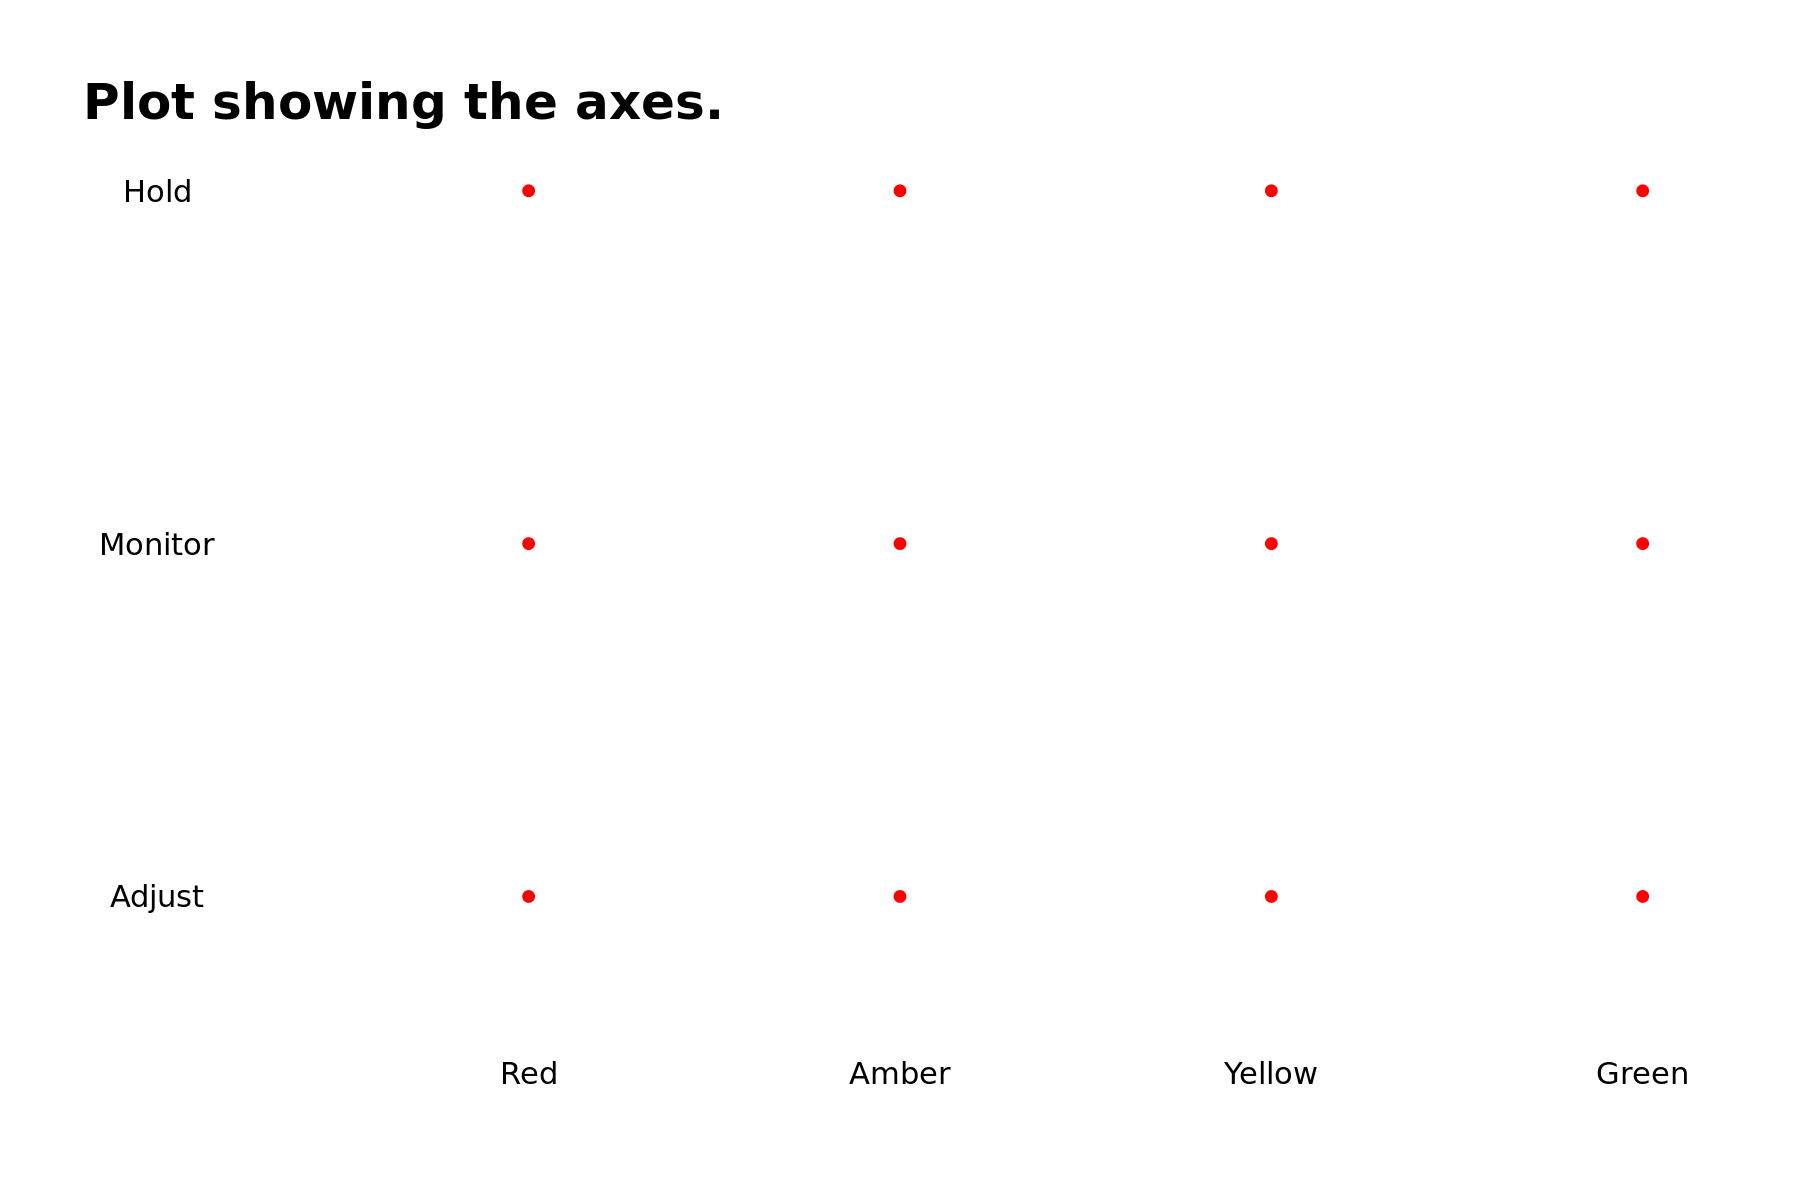

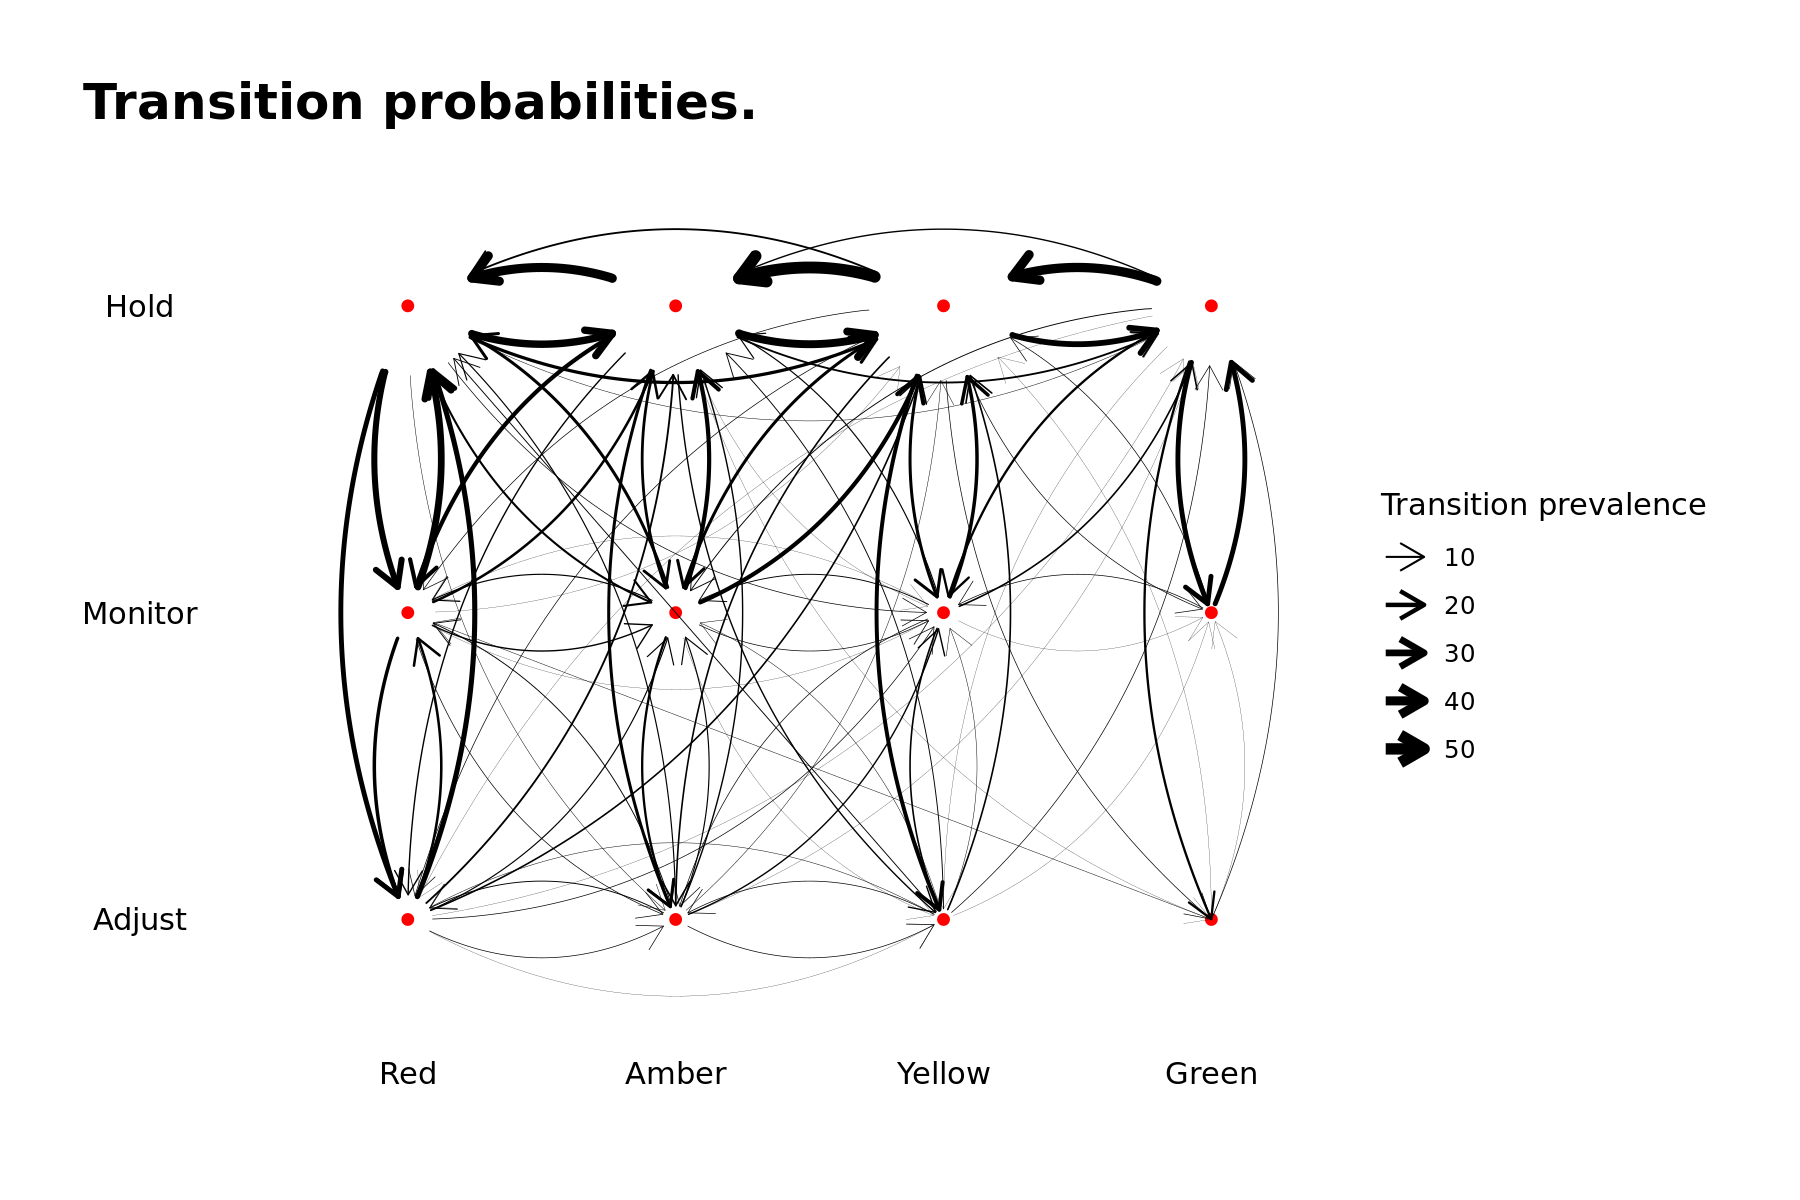

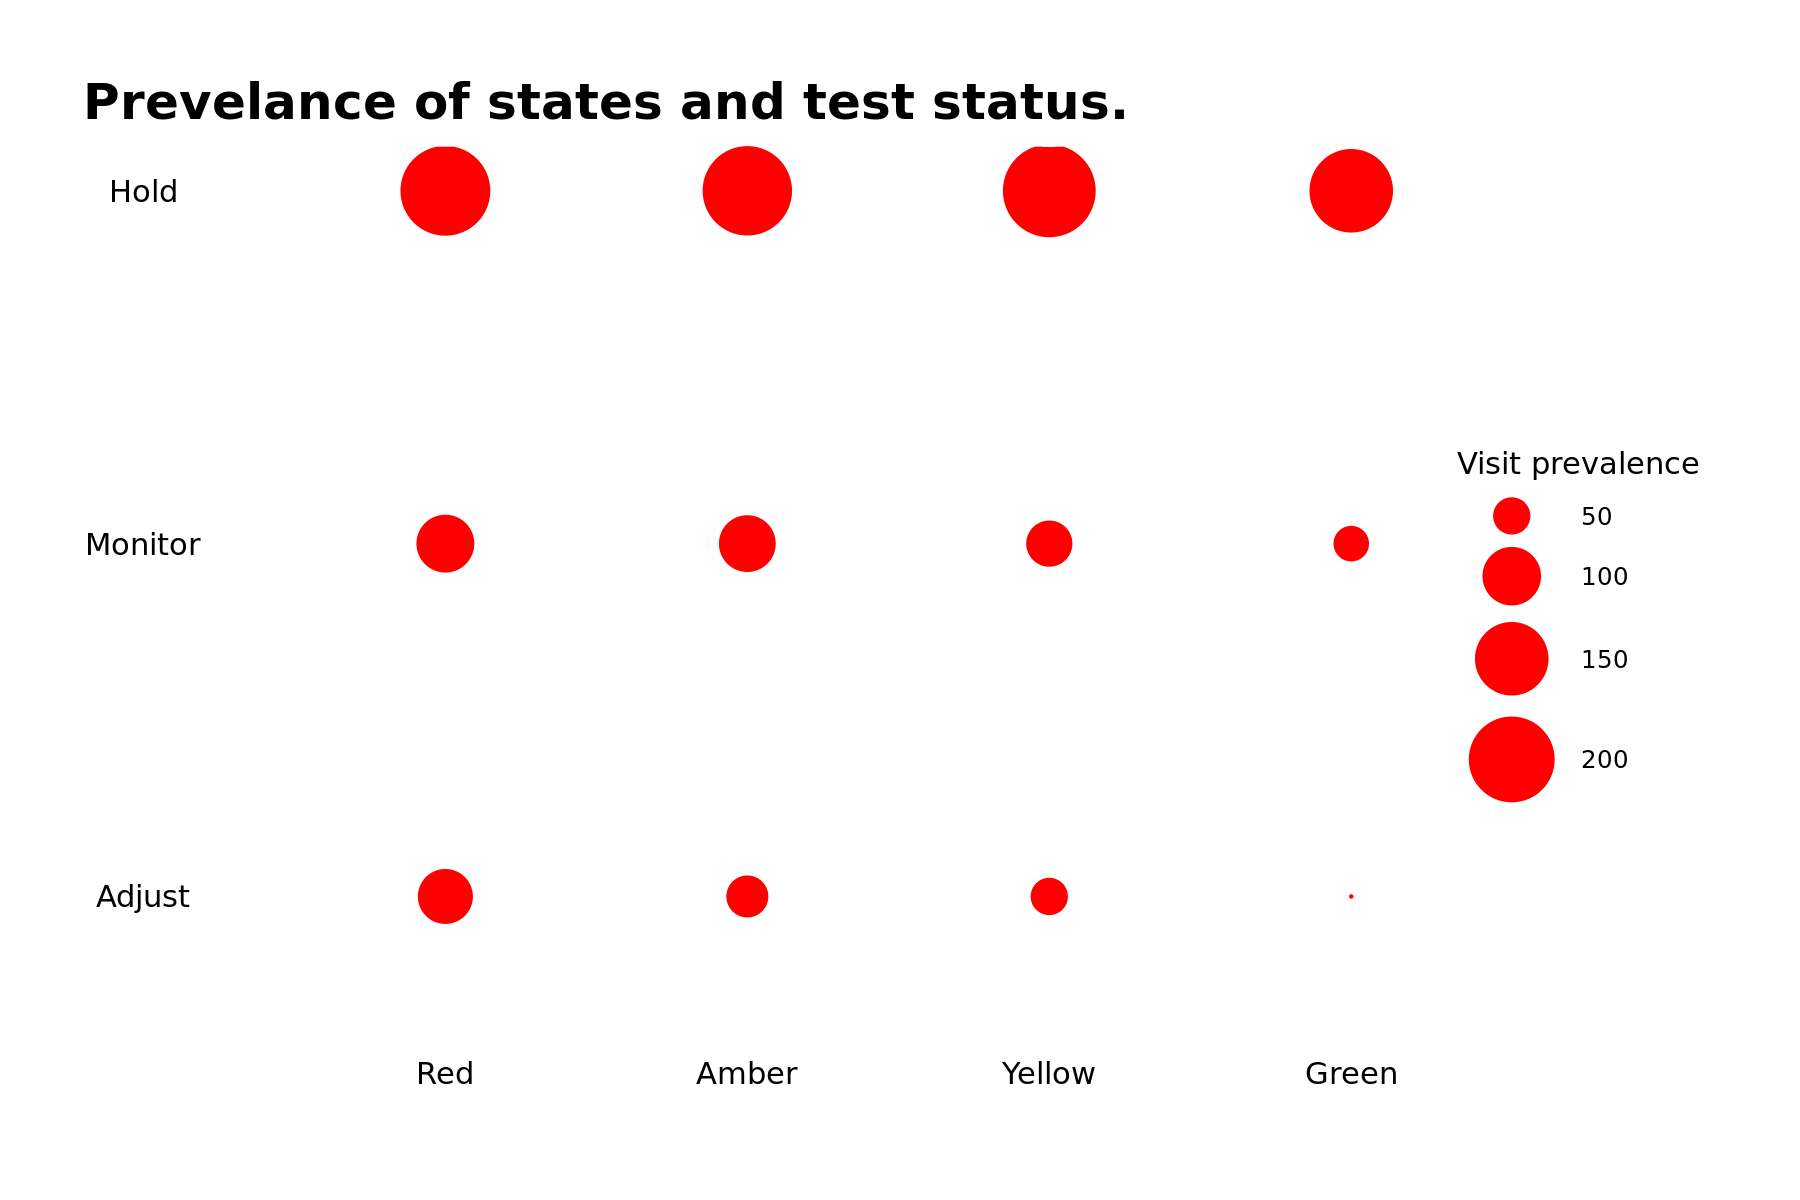

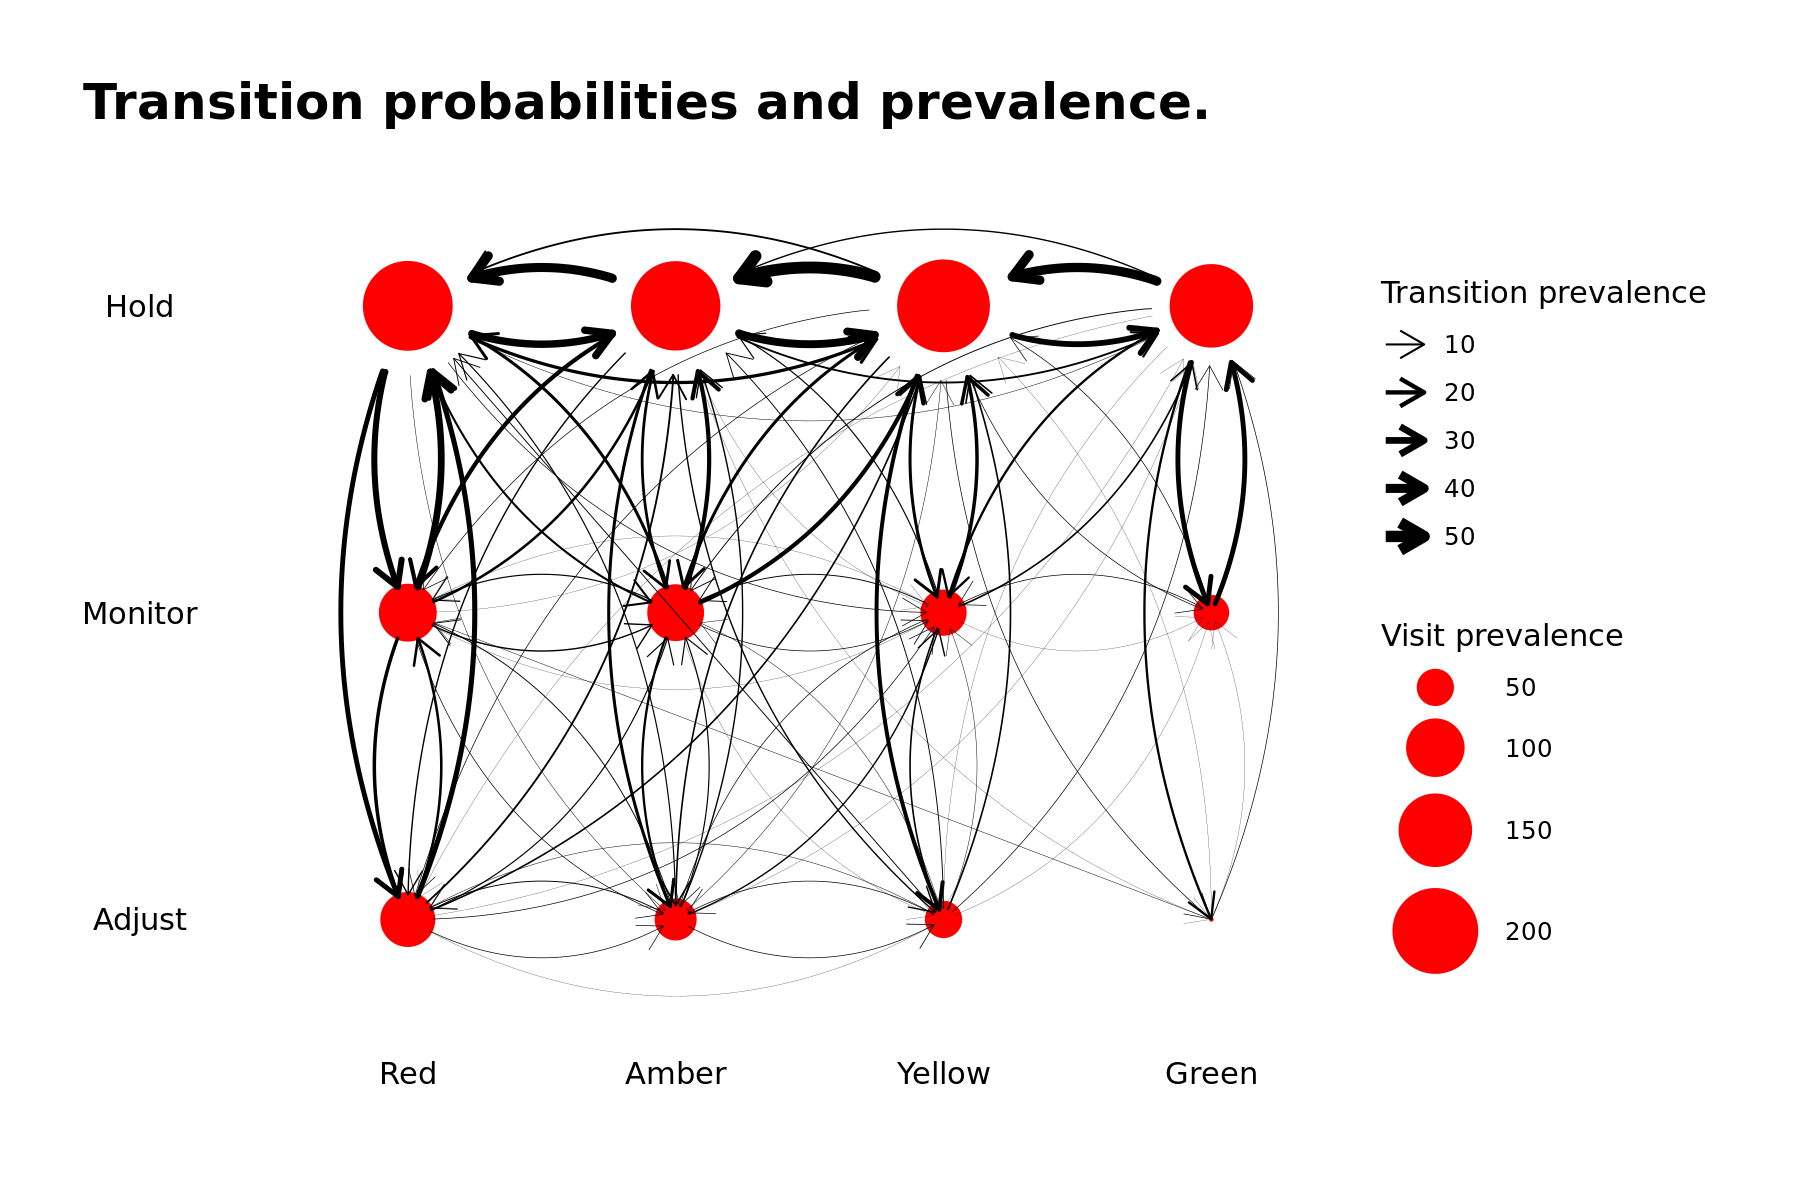

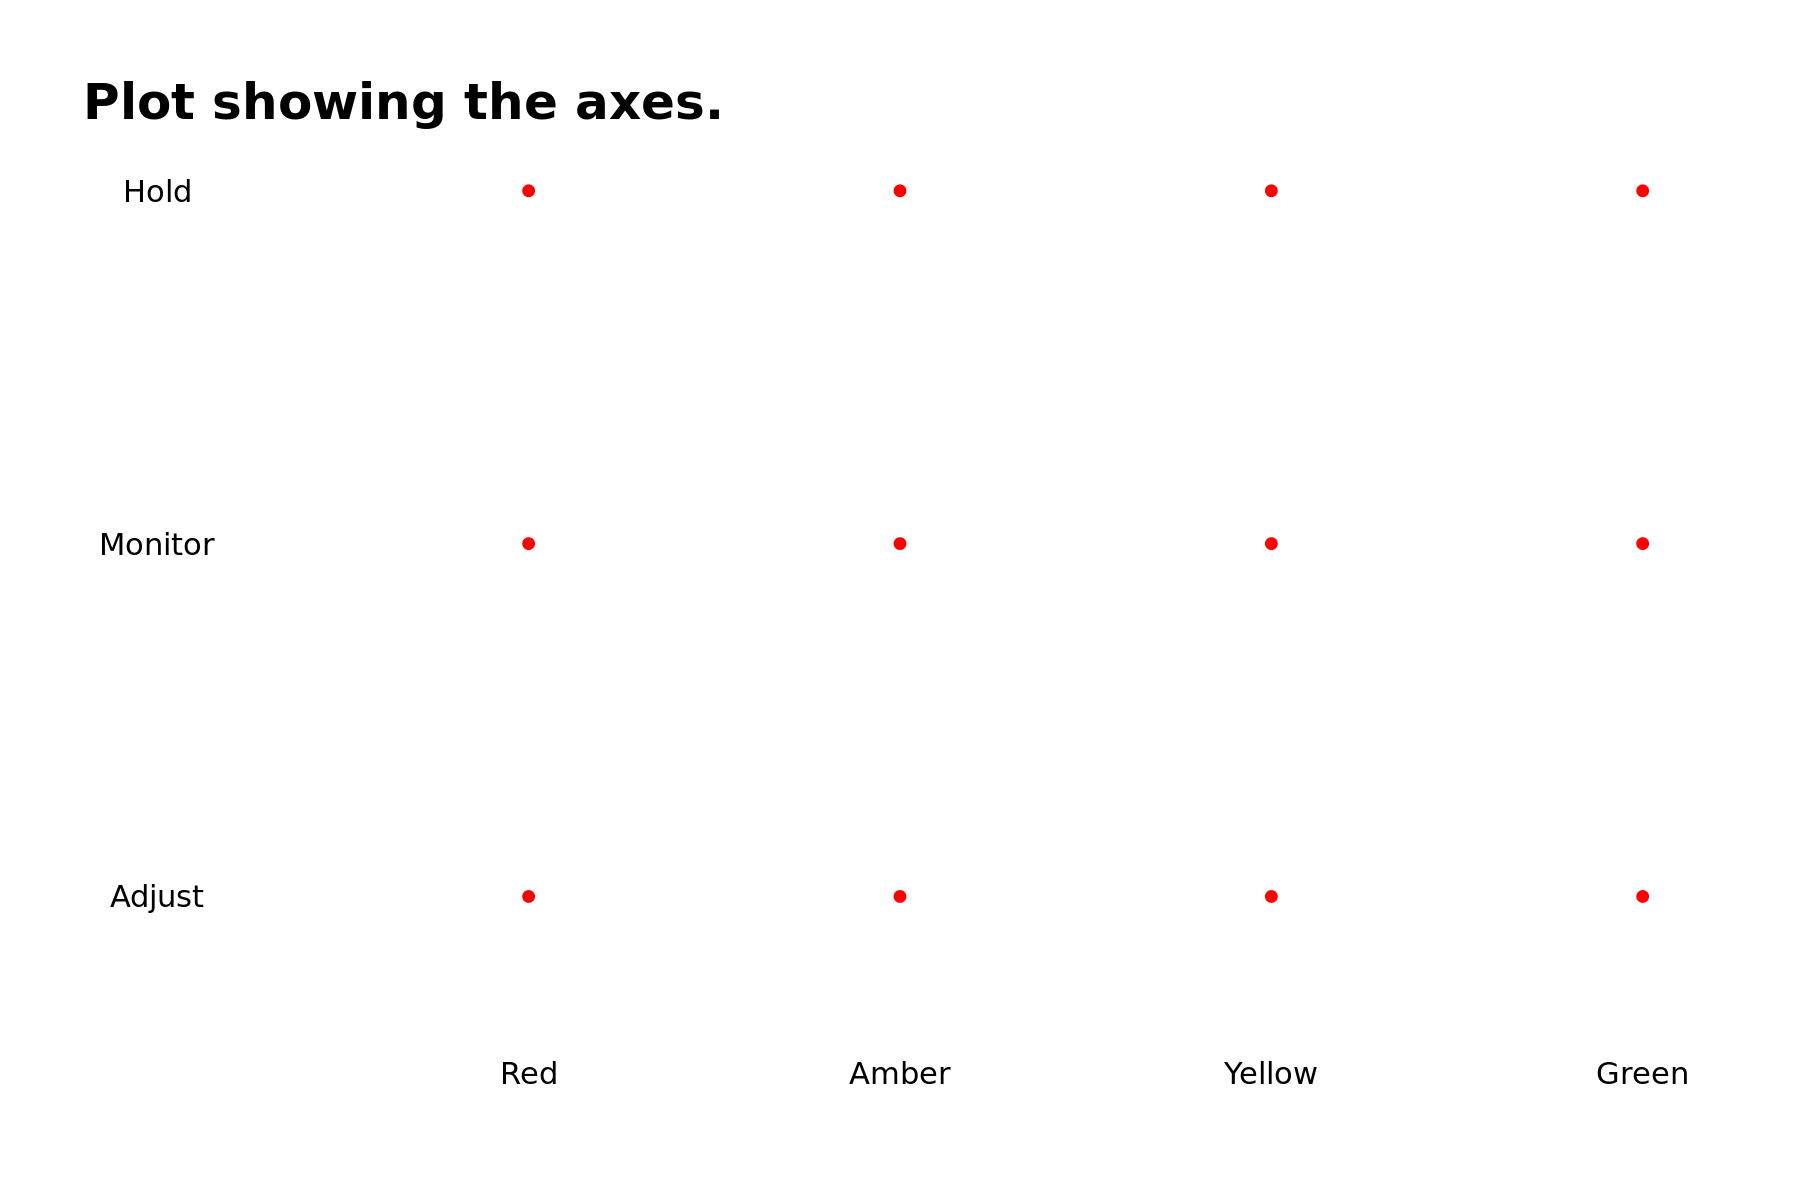

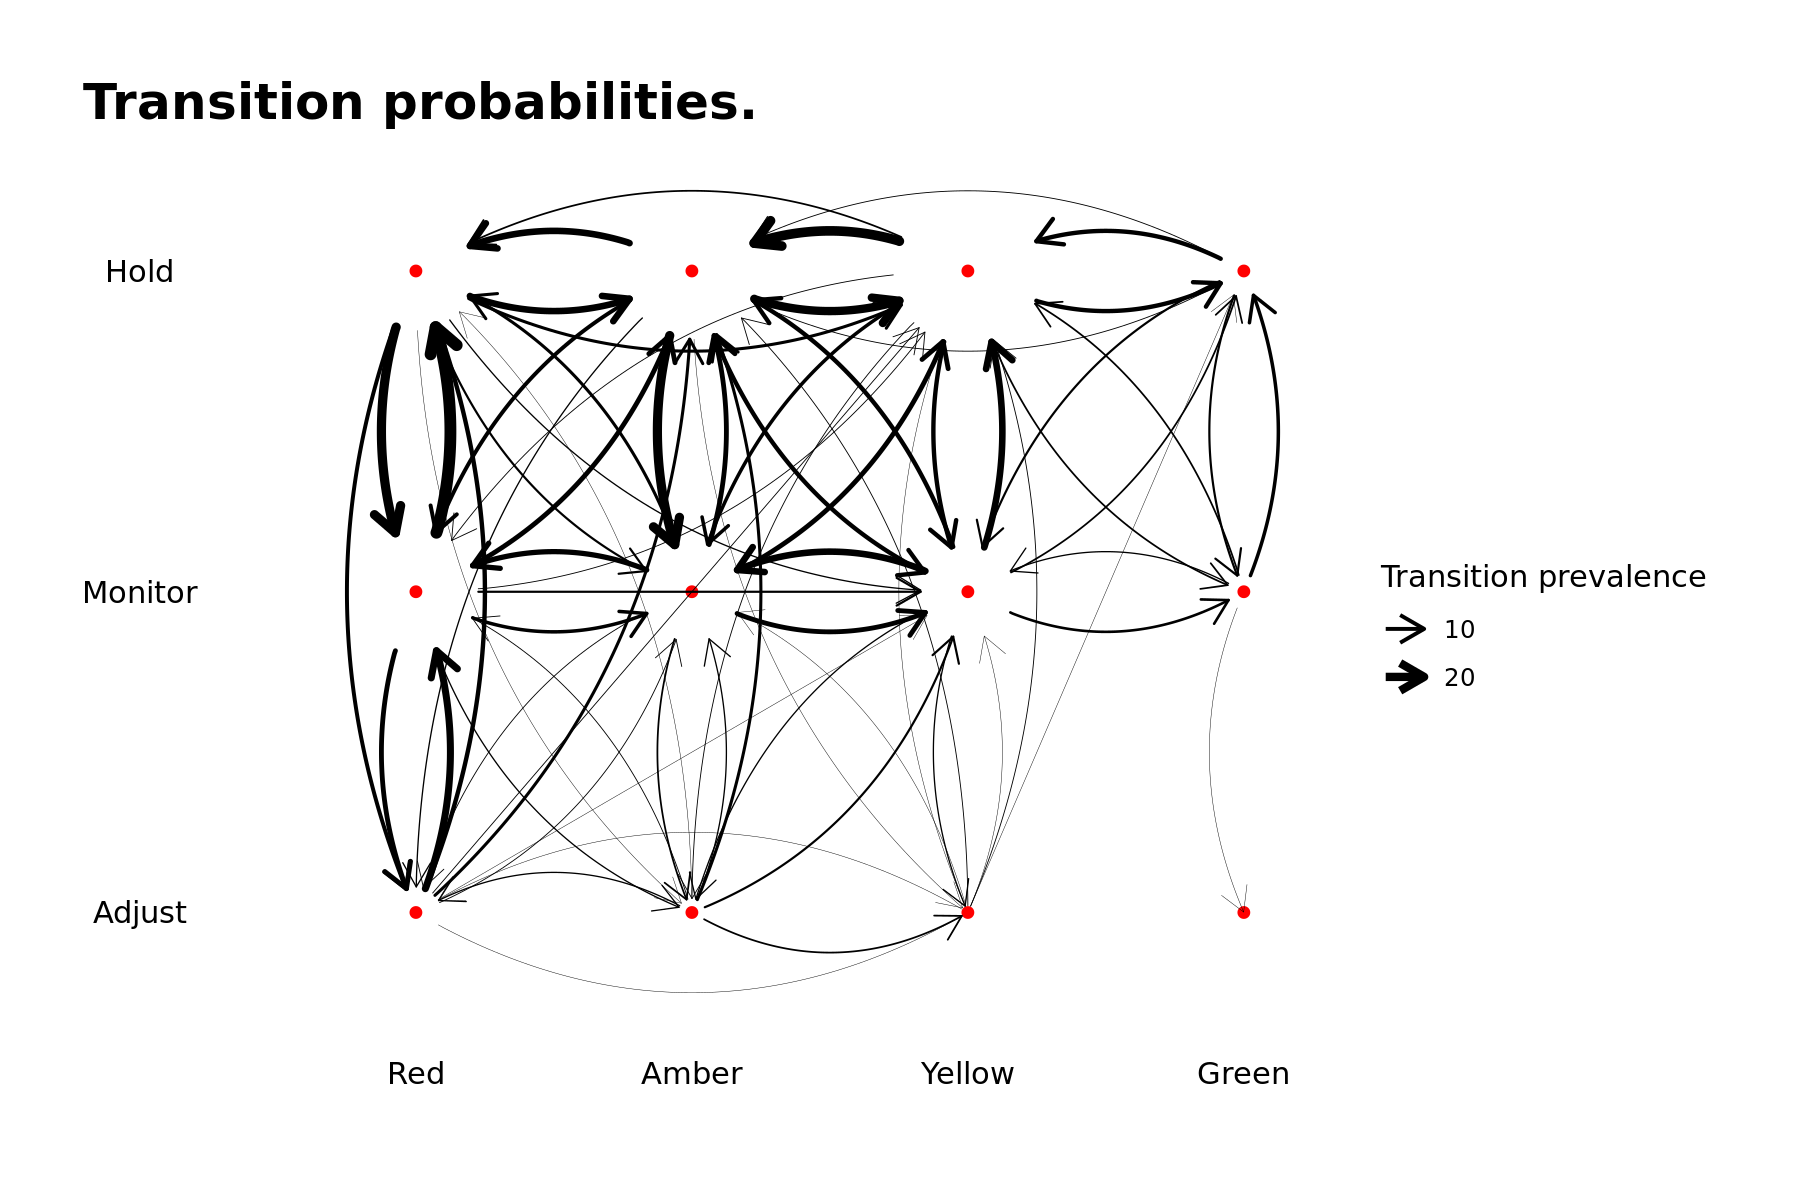

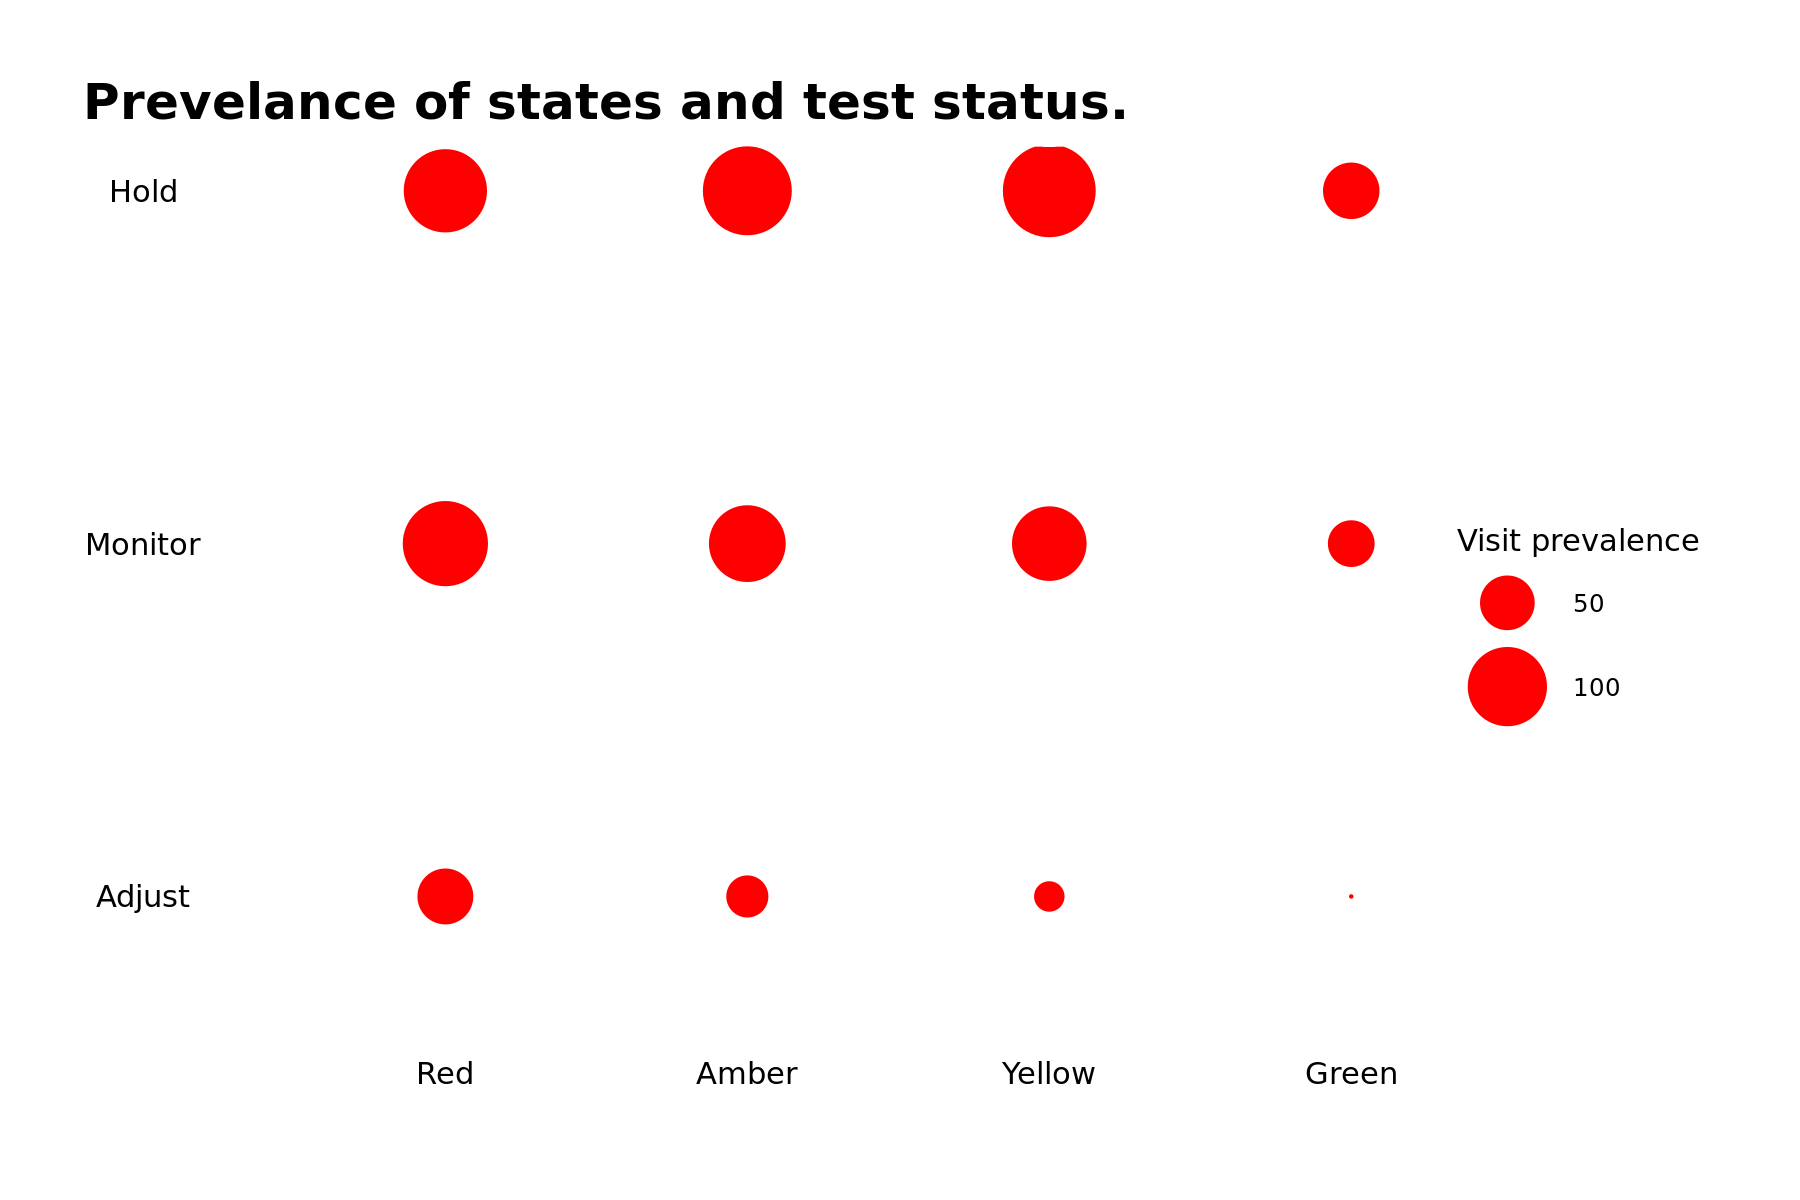

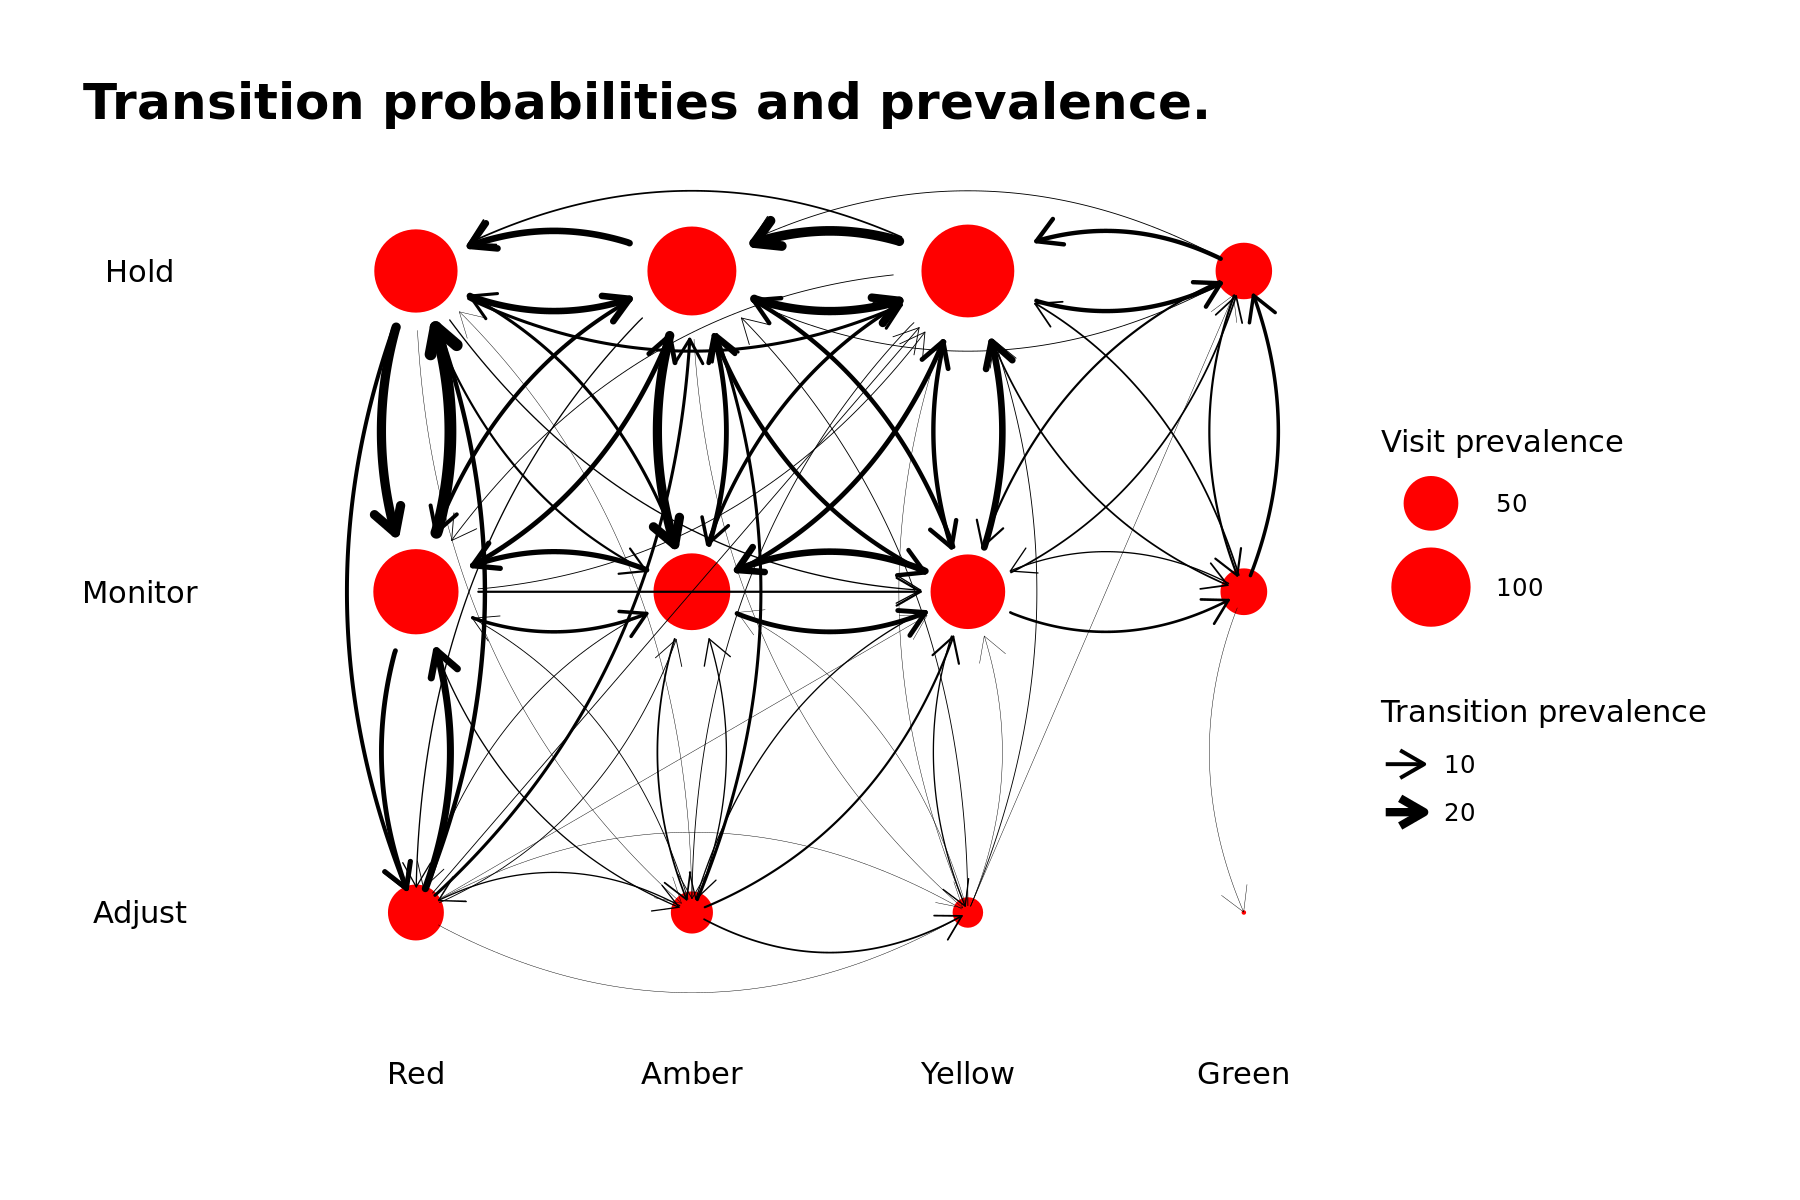

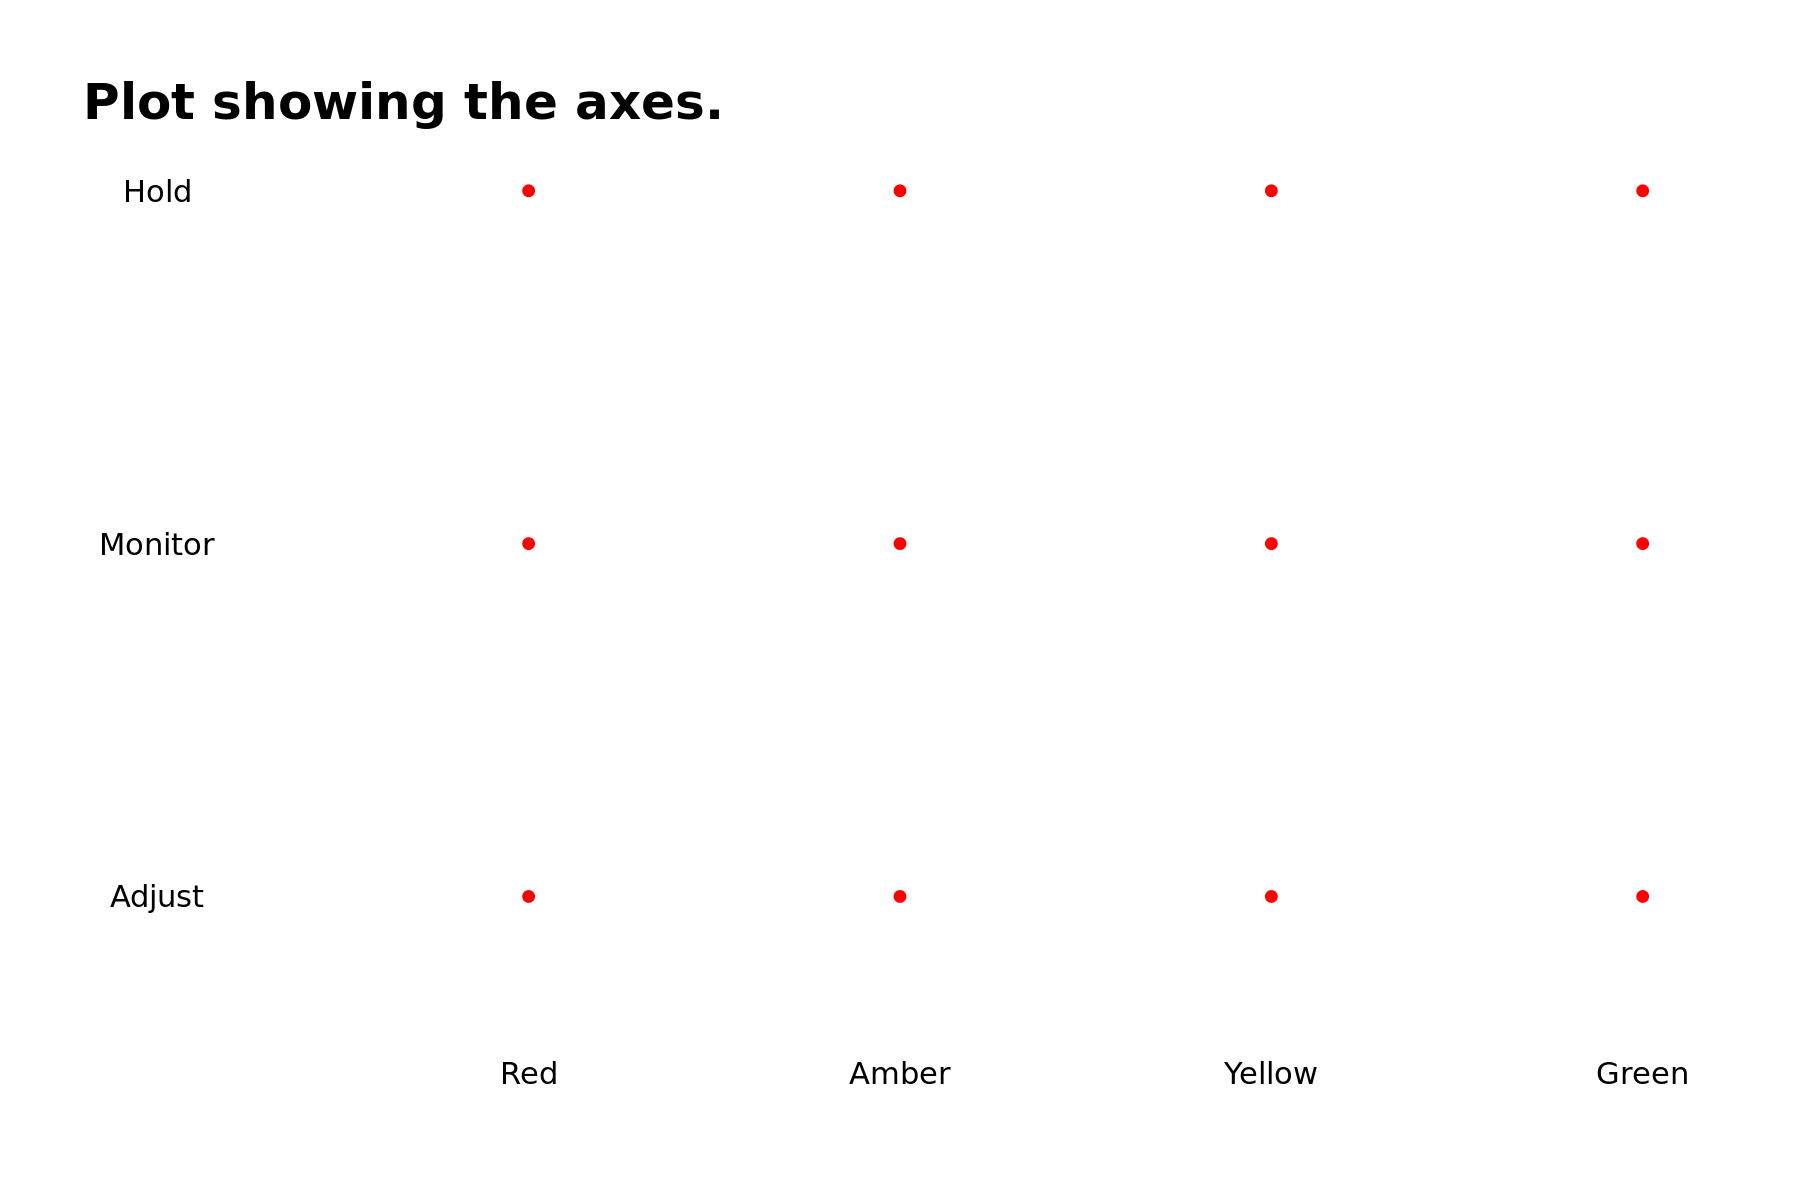

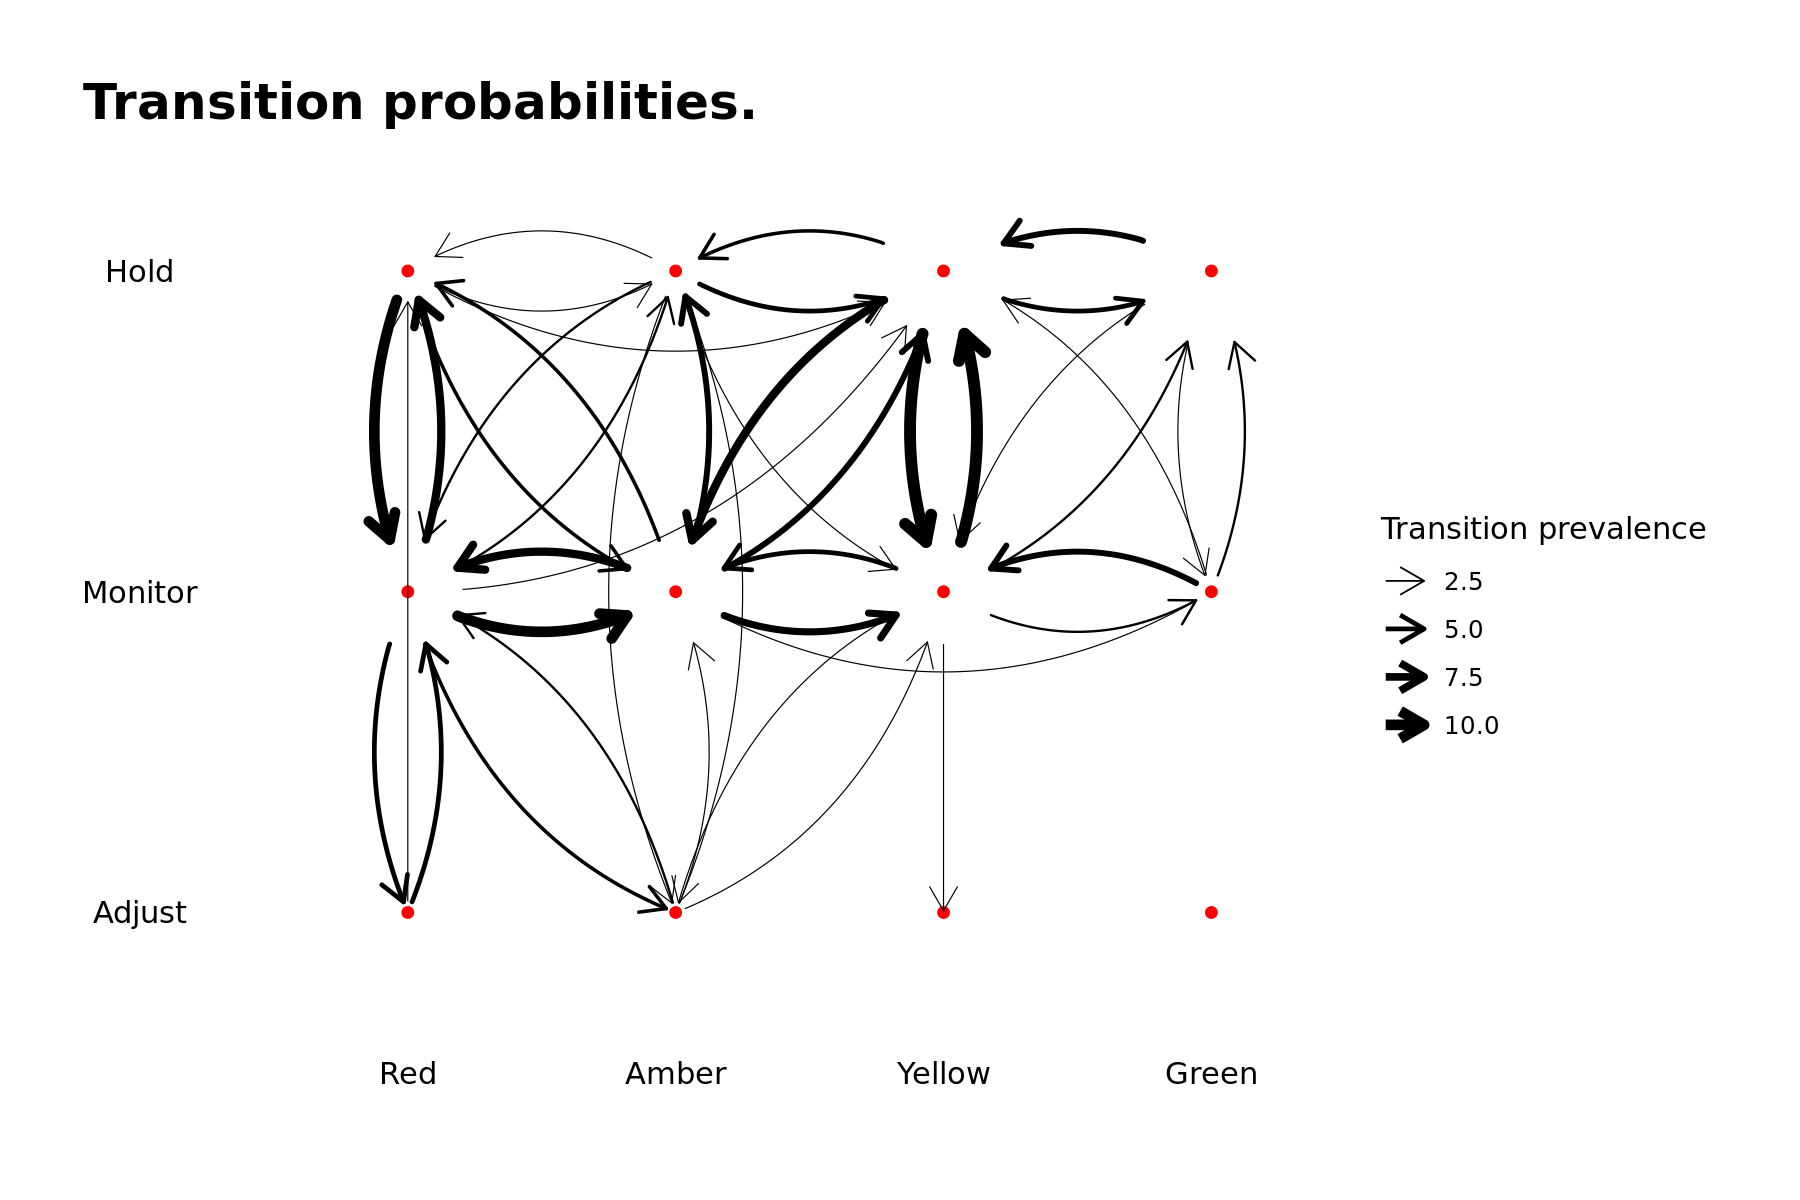

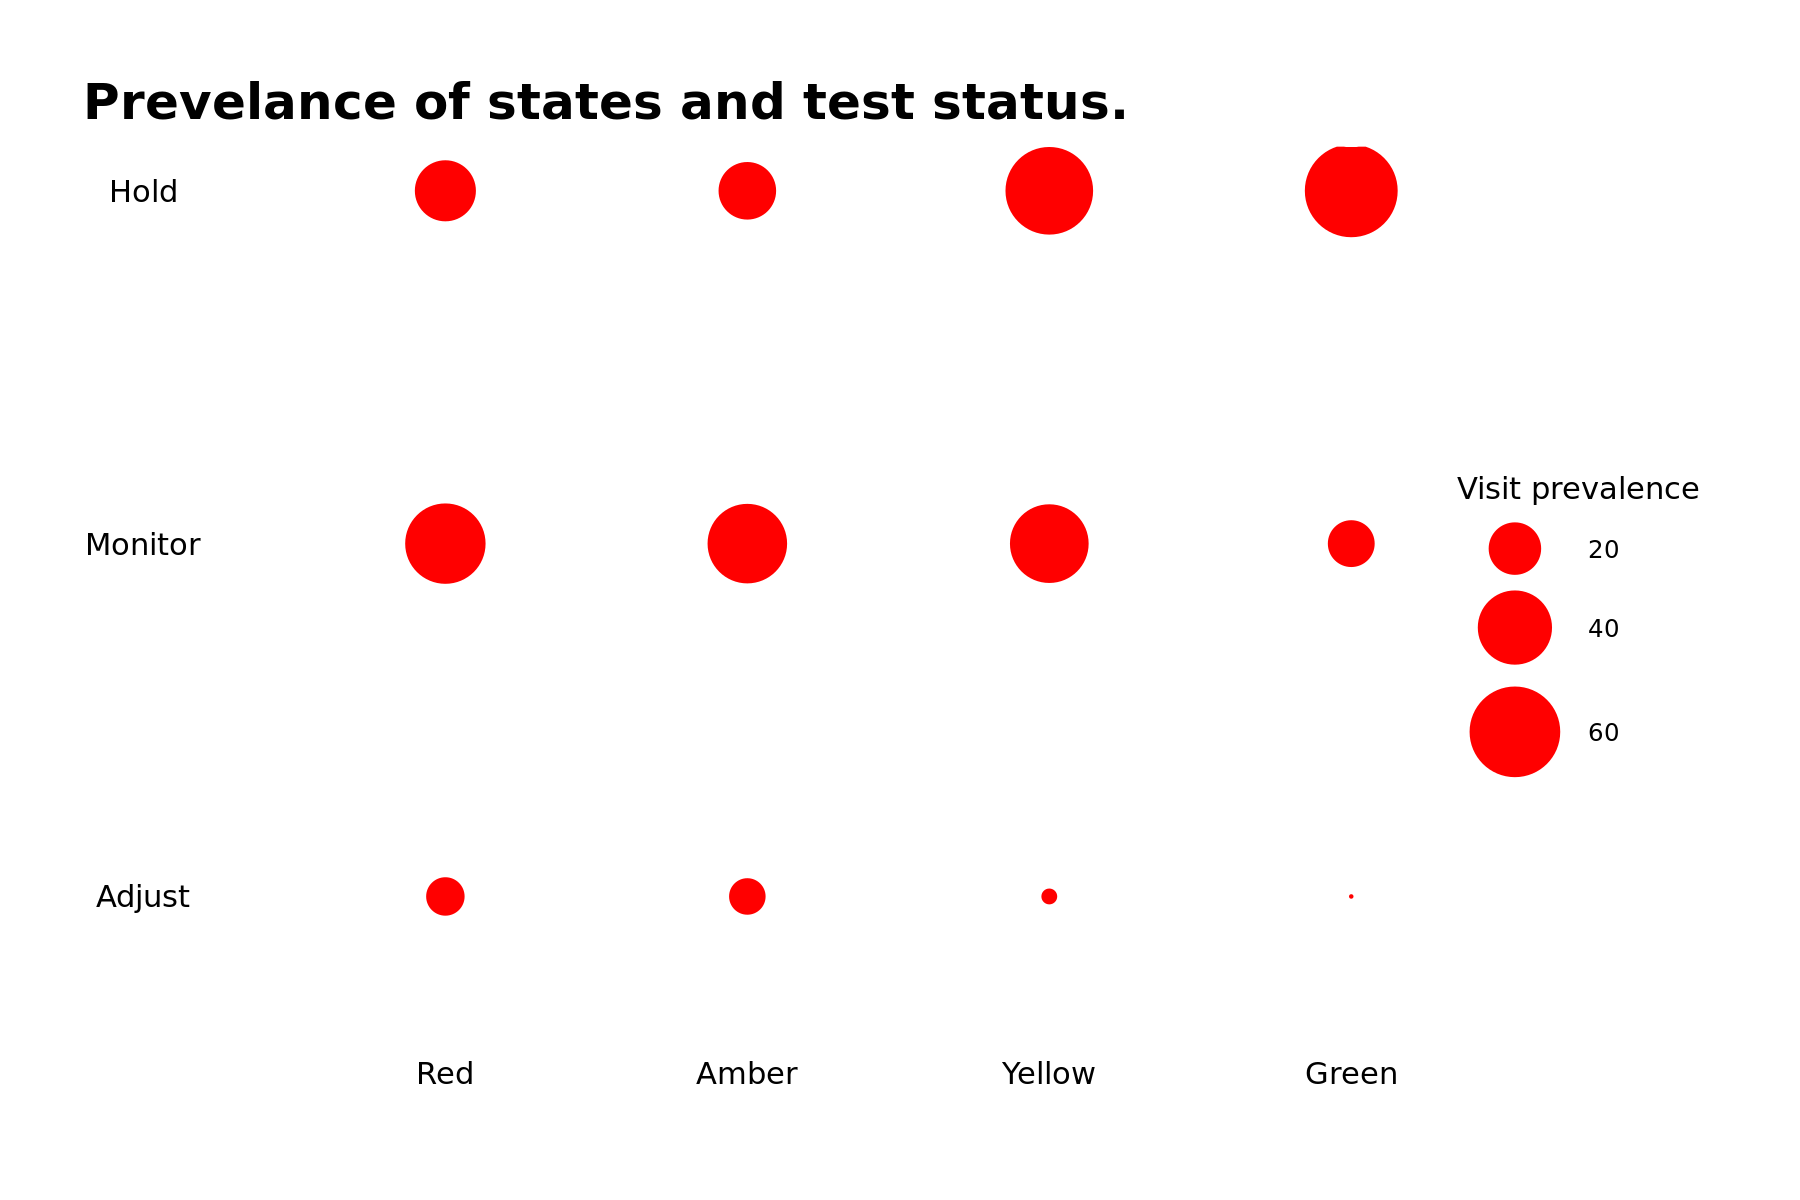

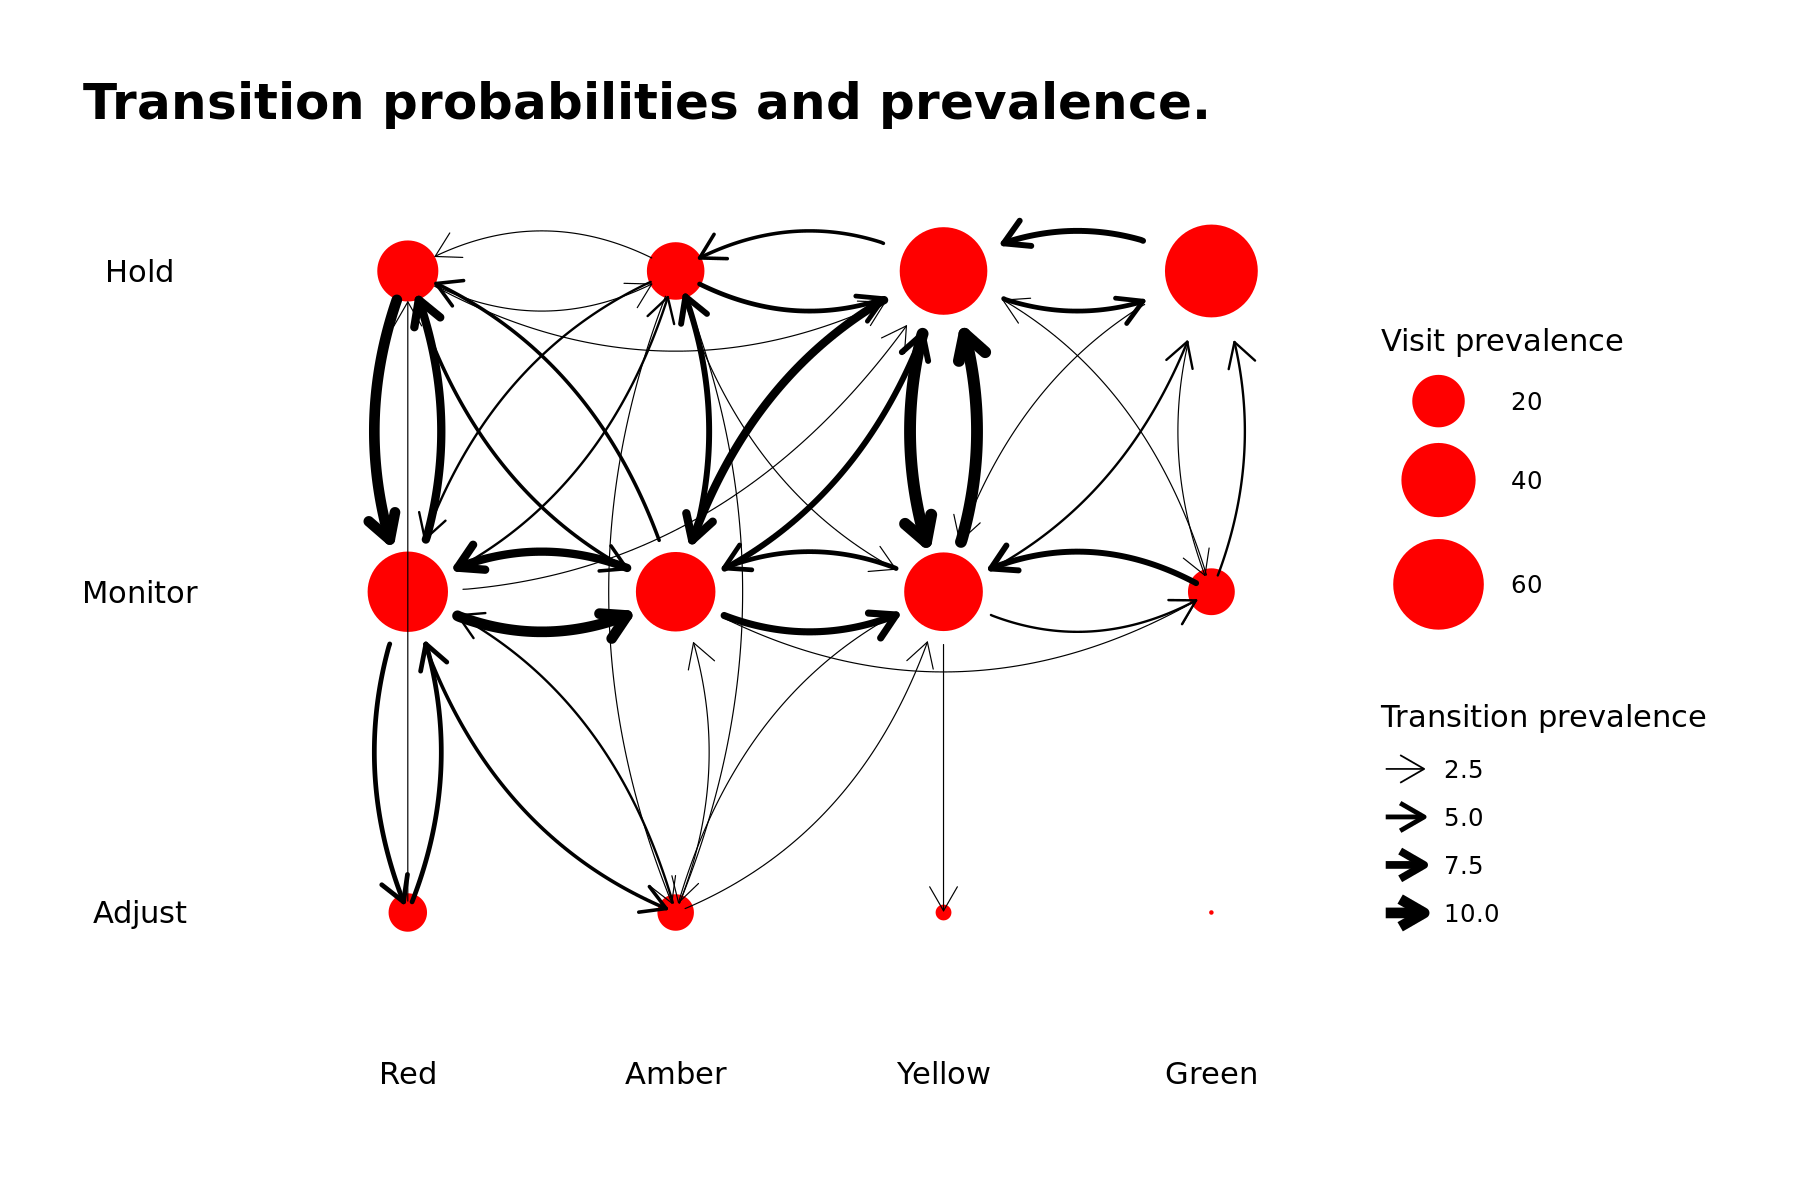

In [384]:
# Define a function to produce the plots.
fnc__plot_transition_matrices <-
    function(
        plot_data = NULL  # A tibble of the plot data.
        ,save.name = NULL # A string to name the CSV that will be saved.
    )
{
   
        
    # Set the data that will be used for all plots.
    my_nodes <- 
        plot_data %>%
        dplyr::group_by( next_node ) %>%
        dplyr::reframe( `Visit prevalence` = n() ) %>%
        dplyr::ungroup() %>%
        dplyr::rename( name = next_node ) %>%
        dplyr::mutate(
            x = rep( 1:4, 3 )
            ,y = c( rep( 3, 4 ), rep( 2, 4 ), rep( 1, 4 ) )
        )

    my_edges <-
        plot_data %>%
        dplyr::group_by( node, next_node )%>%
        dplyr::reframe( `Transition prevalence` = n () ) %>%
        dplyr::ungroup() %>%
        dplyr::rename( from = node, to = next_node ) %>%
        dplyr::mutate( from = as.character( from ), to = as.character( to ) ) %>%
        dplyr::left_join(
            dplyr::select( my_nodes, name, `Visit prevalence` )
            ,by = join_by( from == name )
        ) %>%
        dplyr::rename( start_prevalence = `Visit prevalence`) %>%
        dplyr::left_join(
            dplyr::select( my_nodes, name, `Visit prevalence` )
            ,by = join_by( to == name )
        ) %>%
        dplyr::rename( end_prevalence = `Visit prevalence` ) %>%
        dplyr::mutate(
            norm_start_prevalence = ( start_prevalence - min( start_prevalence ) ) / diff( range( start_prevalence ) )
            ,norm_start_prevalence = norm_start_prevalence * diff( node_size_range ) + node_size_range[1]
            ,norm_end_prevalence = ( end_prevalence - min( end_prevalence ) ) / diff( range( end_prevalence ) )
            ,norm_end_prevalence = norm_end_prevalence * diff( node_size_range ) + node_size_range[1]
        )     
        
    # Set plotting range of node size.
    node_size_range <- c( 0.1, 15 )
        
        
    # Make the plot of the axes.
    graph__axes <-
        tidygraph::tbl_graph( nodes = my_nodes, edges = my_edges ) %>%
        ggraph::ggraph( x = x, y = y ) +
        ggraph::geom_node_point( colour = 'red' ) +
        ggplot2::geom_text(
            data = my_labels
            ,aes( label = label, x = x, y = y )
        ) +
        labs( title = "Plot showing the axes." ) +
        ggraph::theme_graph()
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__axes_", save.name, ".jpg" )
        ,plot = graph__axes
        ,width = width
        ,height = 16
        ,dpi = dpi
        ,units = "cm"
    )
        
    # Make the plot of the visits.
    graph__visits <-
        tidygraph::tbl_graph( nodes = my_nodes, edges = my_edges ) %>%
        ggraph::ggraph( x = x, y = y ) +
        ggraph::geom_node_point( aes( size = `Visit prevalence` ), colour = 'red' ) +
        scale_size( range = node_size_range ) +
        ggplot2::geom_text(
            data = my_labels
            ,aes( label = label, x = x, y = y )
        ) +
        labs( title = "Prevelance of states-test status combinations." ) +
        ggraph::theme_graph()
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__visits_", save.name, ".jpg" )
        ,plot = graph__visits
        ,width = width
        ,height = height
        ,dpi = dpi
        ,units = "cm"
    )
        
    # Make the plot of the transitions.
    graph__transitions <-
        tidygraph::tbl_graph( nodes = my_nodes, edges = my_edges ) %>%
        ggraph::ggraph( x = x, y = y ) +
        geom_image( aes( image = image ) ) + ###### This needs work. I want to use `sefl_transition.svg` as the marker, and adjust it by size. See https://albert-rapp.de/posts/ggplot2-tips/27_images/27_images
        #ggraph::geom_node_point( colour = "red" ) +
        ggraph::geom_edge_fan(
            aes(
                start_cap = ggraph::circle( my_edges$norm_start_prevalence * 1.8, "pt" )
                ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 1.8, "pt" )
                ,width = `Transition prevalence`
            )
            ,lineend = 'round'
            ,arrow = grid::arrow( length = unit( 10, "points" ) )
            ,strength = 2 # use 0.6 if using `geom_edge_bend()`
        ) +
        ggraph::scale_edge_width( range = c( 0.001, 2 ) ) +
        ggplot2::geom_text(
            data = my_labels
            ,aes( label = label, x = x, y = y )
        ) +
        labs( title = "Transition probabilities." ) +
        ggraph::theme_graph()
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__transitions_", save.name, ".jpg" )
        ,plot = graph__transitions
        ,width = width
        ,height = height
        ,dpi = dpi
        ,units = "cm"
    )
    
    # Make the complete plot.
    graph__complete <-
        graph__visits +
        ggraph::geom_edge_fan(
            aes(
                start_cap = ggraph::circle( my_edges$norm_start_prevalence * 1.8, "pt" )
                ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 1.8, "pt" )
                ,width = `Transition prevalence`
            )
            ,lineend = 'round'
            ,arrow = grid::arrow( length = unit( 10, "points" ) )
            ,strength = 2 # use 0.6 if using `geom_edge_bend()`
        ) +
        labs( title = "Transition probabilities and prevalence." ) +
        ggraph::scale_edge_width( range = c( 0.001, 2 ) )
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__complete_", save.name, ".jpg" )
        ,plot = graph__complete
        ,width = width
        ,height = height
        ,dpi = dpi
        ,units = "cm"
    )
        
    # Show all the graphs.
    suppressWarnings( print( graph__axes ) )
    suppressWarnings( print( graph__transitions ) )
    suppressWarnings( print( graph__visits ) )
    suppressWarnings( print( graph__complete ) )

}


fnc__plot_transition_matrices( plot_data = transitions__exactly_5, save.name = "exactly_5" )
fnc__plot_transition_matrices( plot_data = transitions__exactly_10, save.name = "exactly_10" )
fnc__plot_transition_matrices( plot_data = transitions__exactly_15, save.name = "exactly_15" )

In [346]:
?ggsave

ggsave {ggplot2},R Documentation
filename,File name to create on disk.
plot,"Plot to save, defaults to last plot displayed."
device,"Device to use. Can either be a device function (e.g. png), or one of ""eps"", ""ps"", ""tex"" (pictex), ""pdf"", ""jpeg"", ""tiff"", ""png"", ""bmp"", ""svg"" or ""wmf"" (windows only). If NULL (default), the device is guessed based on the filename extension."
path,Path of the directory to save plot to: path and filename are combined to create the fully qualified file name. Defaults to the working directory.
scale,Multiplicative scaling factor.
"width, height","Plot size in units expressed by the units argument. If not supplied, uses the size of the current graphics device."
units,"One of the following units in which the width and height arguments are expressed: ""in"", ""cm"", ""mm"" or ""px""."
dpi,"Plot resolution. Also accepts a string input: ""retina"" (320), ""print"" (300), or ""screen"" (72). Only applies when converting pixel units, as is typical for raster output types."
limitsize,"When TRUE (the default), ggsave() will not save images larger than 50x50 inches, to prevent the common error of specifying dimensions in pixels."
bg,"Background colour. If NULL, uses the plot.background fill value from the plot theme."


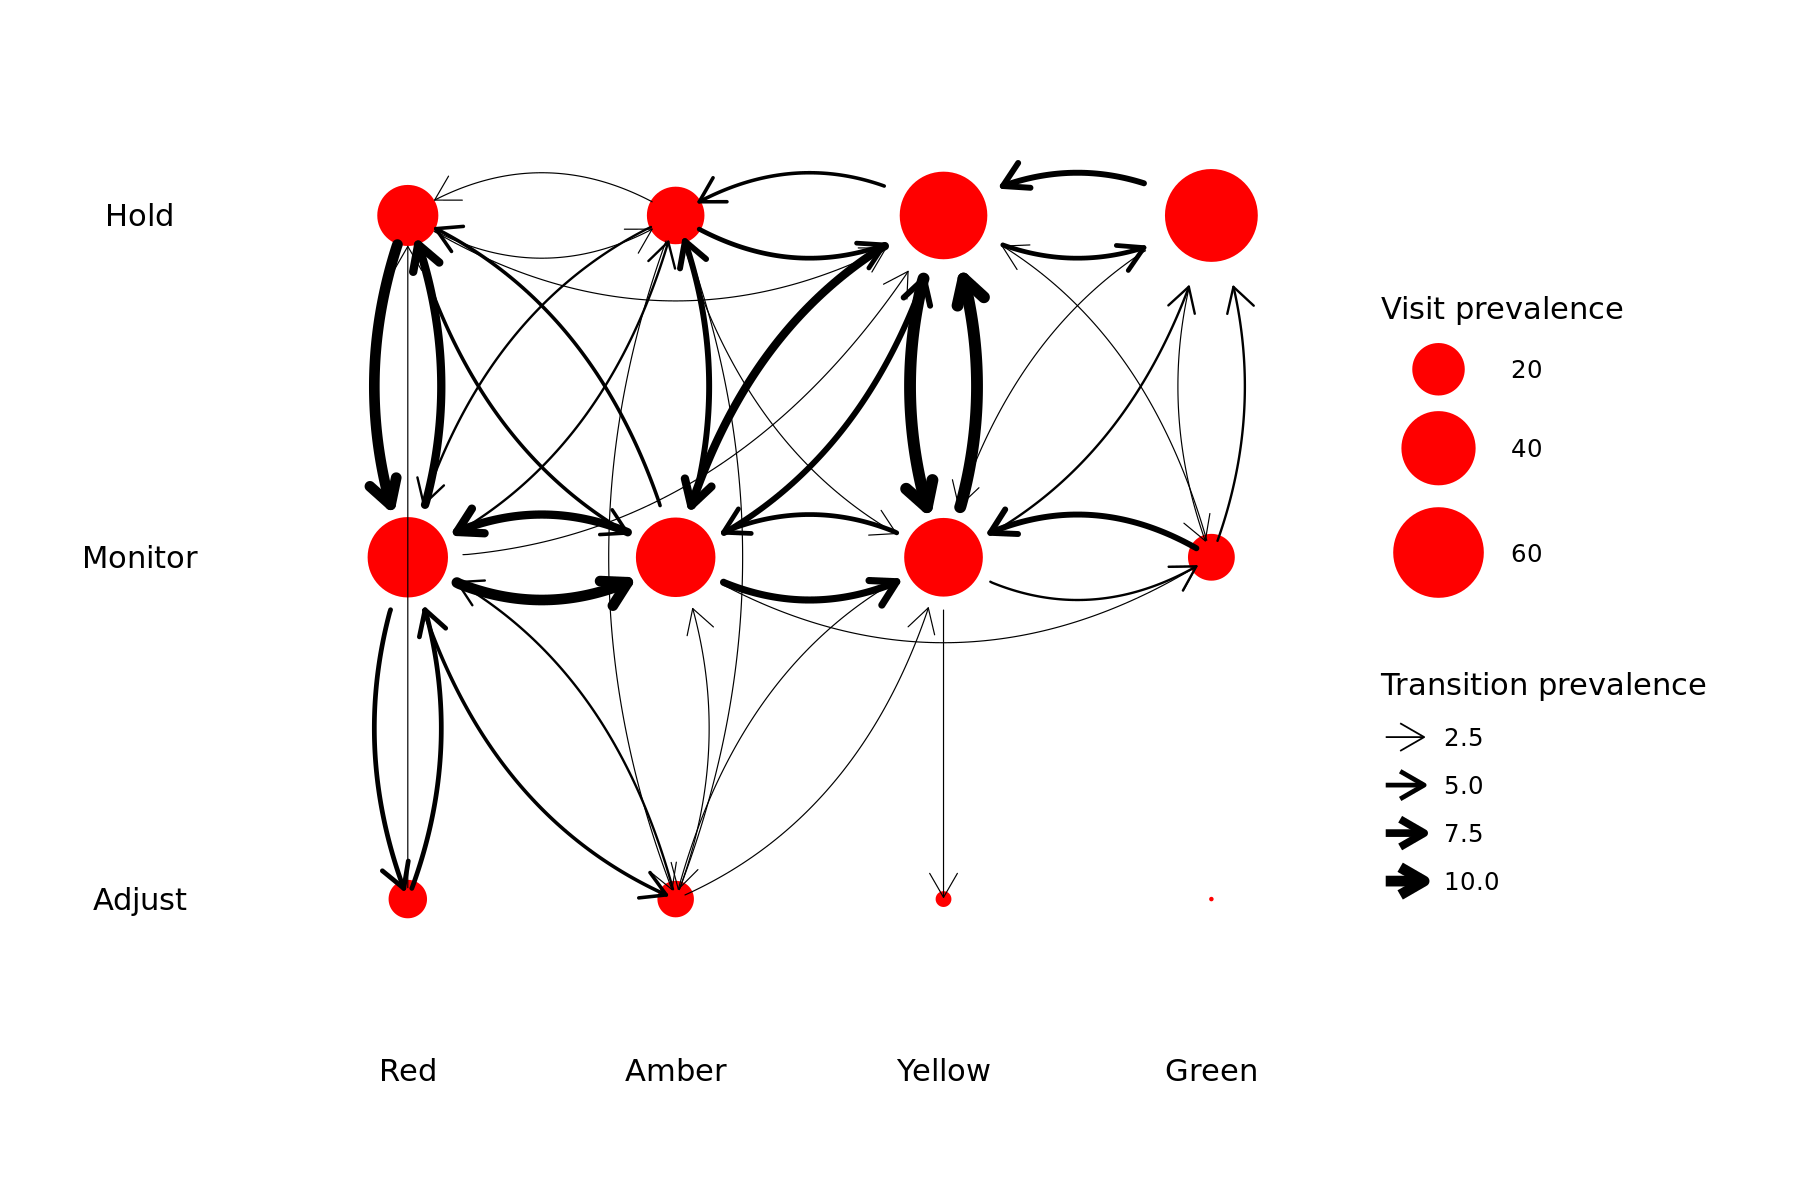

In [337]:
# Set display options.
options( repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200 )
# Set plotting range of node size.
node_size_range <- c( 0.1, 15 )

my_nodes <- 
    a %>%
    dplyr::group_by( next_node ) %>%
    dplyr::reframe( `Visit prevalence` = n() ) %>%
    dplyr::ungroup() %>%
    dplyr::rename( name = next_node ) %>%
    dplyr::mutate(
        x = rep( 1:4, 3 )
        ,y = c( rep( 3, 4 ), rep( 2, 4 ), rep( 1, 4 ) )
    )

my_edges <-
    a %>%
    dplyr::group_by( node, next_node )%>%
    dplyr::reframe( `Transition prevalence` = n () ) %>%
    dplyr::ungroup() %>%
    dplyr::rename( from = node, to = next_node ) %>%
    dplyr::mutate( from = as.character( from ), to = as.character( to ) ) %>%
    dplyr::left_join(
        dplyr::select( my_nodes, name, `Visit prevalence` )
        ,by = join_by( from == name )
    ) %>%
    dplyr::rename( start_prevalence = `Visit prevalence`) %>%
    dplyr::left_join(
        dplyr::select( my_nodes, name, `Visit prevalence` )
        ,by = join_by( to == name )
    ) %>%
    dplyr::rename( end_prevalence = `Visit prevalence` ) %>%
    dplyr::mutate(
        norm_start_prevalence = ( start_prevalence - min( start_prevalence ) ) / diff( range( start_prevalence ) )
        ,norm_start_prevalence = norm_start_prevalence * diff( node_size_range ) + node_size_range[1]
        ,norm_end_prevalence = ( end_prevalence - min( end_prevalence ) ) / diff( range( end_prevalence ) )
        ,norm_end_prevalence = norm_end_prevalence * diff( node_size_range ) + node_size_range[1]
    )

my_labels <-
    data.frame(
        label = c( 'Hold', 'Monitor', 'Adjust', 'Red', 'Amber', 'Yellow', 'Green')
        ,x = c( rep( 0, 3 ), 1:4)
        ,y = c(  3:1, rep( 0.5, 4) )
    )

my_graph <-
    tidygraph::tbl_graph(
            nodes = my_nodes
            ,edges = my_edges
        ) %>%
    ggraph::ggraph( x = x, y = y ) +
    ggraph::geom_node_point( aes( size = `Visit prevalence` ), colour = 'red' ) +
    scale_size( range = c( .1, 15 ) ) +
    ggraph::geom_edge_fan(
        aes(
            start_cap = ggraph::circle( my_edges$norm_start_prevalence * 1.8, "pt" )
            ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 1.8, "pt" )
            ,width = `Transition prevalence`
        )
        ,lineend = 'round'
        ,arrow = grid::arrow( length = unit( 10, "points" ) )
        ,strength = 2 # use 0.6 if using `geom_edge_bend()`
    ) +
    ggraph::scale_edge_width( range = c( 0.001, 2 ) ) +
    ggplot2::geom_text(
        data = my_labels
        ,aes( label = label, x = x, y = y )
    ) +
    ggraph::theme_graph()

suppressWarnings( print( my_graph ) )
# Lots of help from the first FAQ, here: https://schochastics.github.io/netVizR/#FAQ

My comments on the plot above are:

1. Reciprocal transitions are always similar but not exact.
2. The busiest activity is between the Hold and Monitor states when the test status is Red or Amber.